# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate
    #return None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):      
        
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        bn2 = tf.layers.batch_normalization(relu2, training=True)
        # 7x7x128
        
        
        x3 = tf.layers.conv2d(bn2, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        bn3 = tf.layers.batch_normalization(relu3, training=True)
        # 4x4x256
        
        flat = tf.reshape(bn3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        
        
        
        return out, logits

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=reuse):  
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss
    
    
    #g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    #d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    #d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    #smooth = 0.1
    #real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    #fake_labels = tf.zeros_like(d_fake_out)
    #g_labels    = tf.ones_like(d_fake_out)

    #d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    #d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    #g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    #d_loss = d_real_loss + d_fake_loss
    #return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    #return d_train_opt, g_train_opt
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                print('Iteration:', steps)
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                
                if steps % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Epoch 10/2... Discriminator Loss: 0.4031... Generator Loss: 1.4657
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Epoch 20/2... Discriminator Loss: 0.1493... Generator Loss: 2.5748
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Epoch 30/2... Discriminator Loss: 0.1216... Generator Loss: 3.0582
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Epoch 40/2... Discriminator Loss: 0.0903... Generator Loss: 2.8955
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Epoch 50/2... Discriminator Loss: 0.0532... Generator Loss: 3.5527


Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Epoch 60/2... Discriminator Loss: 0.0413... Generator Loss: 3.8123
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Epoch 70/2... Discriminator Loss: 0.0586... Generator Loss: 3.5927
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Epoch 80/2... Discriminator Loss: 0.0382... Generator Loss: 4.0804
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Epoch 90/2... Discriminator Loss: 4.7470... Generator Loss: 0.1828
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Epoch 100/2... Discriminator Loss: 0.1628... Generator Loss: 4.1954


Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110
Epoch 110/2... Discriminator Loss: 0.9191... Generator Loss: 2.3449
Step: 111
Step: 112
Step: 113
Step: 114
Step: 115
Step: 116
Step: 117
Step: 118
Step: 119
Step: 120
Epoch 120/2... Discriminator Loss: 1.5124... Generator Loss: 1.8297
Step: 121
Step: 122
Step: 123
Step: 124
Step: 125
Step: 126
Step: 127
Step: 128
Step: 129
Step: 130
Epoch 130/2... Discriminator Loss: 1.1600... Generator Loss: 2.3597
Step: 131
Step: 132
Step: 133
Step: 134
Step: 135
Step: 136
Step: 137
Step: 138
Step: 139
Step: 140
Epoch 140/2... Discriminator Loss: 1.0969... Generator Loss: 2.1606
Step: 141
Step: 142
Step: 143
Step: 144
Step: 145
Step: 146
Step: 147
Step: 148
Step: 149
Step: 150
Epoch 150/2... Discriminator Loss: 0.9296... Generator Loss: 2.6038


Step: 151
Step: 152
Step: 153
Step: 154
Step: 155
Step: 156
Step: 157
Step: 158
Step: 159
Step: 160
Epoch 160/2... Discriminator Loss: 5.1391... Generator Loss: 0.0087
Step: 161
Step: 162
Step: 163
Step: 164
Step: 165
Step: 166
Step: 167
Step: 168
Step: 169
Step: 170
Epoch 170/2... Discriminator Loss: 0.8374... Generator Loss: 1.3327
Step: 171
Step: 172
Step: 173
Step: 174
Step: 175
Step: 176
Step: 177
Step: 178
Step: 179
Step: 180
Epoch 180/2... Discriminator Loss: 0.8640... Generator Loss: 0.7632
Step: 181
Step: 182
Step: 183
Step: 184
Step: 185
Step: 186
Step: 187
Step: 188
Step: 189
Step: 190
Epoch 190/2... Discriminator Loss: 0.5627... Generator Loss: 1.5268
Step: 191
Step: 192
Step: 193
Step: 194
Step: 195
Step: 196
Step: 197
Step: 198
Step: 199
Step: 200
Epoch 200/2... Discriminator Loss: 0.6785... Generator Loss: 1.7670


Step: 201
Step: 202
Step: 203
Step: 204
Step: 205
Step: 206
Step: 207
Step: 208
Step: 209
Step: 210
Epoch 210/2... Discriminator Loss: 0.6176... Generator Loss: 2.2869
Step: 211
Step: 212
Step: 213
Step: 214
Step: 215
Step: 216
Step: 217
Step: 218
Step: 219
Step: 220
Epoch 220/2... Discriminator Loss: 0.8827... Generator Loss: 0.6837
Step: 221
Step: 222
Step: 223
Step: 224
Step: 225
Step: 226
Step: 227
Step: 228
Step: 229
Step: 230
Epoch 230/2... Discriminator Loss: 0.2894... Generator Loss: 2.4432
Step: 231
Step: 232
Step: 233
Step: 234
Step: 235
Step: 236
Step: 237
Step: 238
Step: 239
Step: 240
Epoch 240/2... Discriminator Loss: 0.2705... Generator Loss: 2.2546
Step: 241
Step: 242
Step: 243
Step: 244
Step: 245
Step: 246
Step: 247
Step: 248
Step: 249
Step: 250
Epoch 250/2... Discriminator Loss: 0.5554... Generator Loss: 1.1799


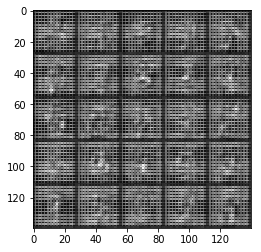

Step: 251
Step: 252
Step: 253
Step: 254
Step: 255
Step: 256
Step: 257
Step: 258
Step: 259
Step: 260
Epoch 260/2... Discriminator Loss: 0.3645... Generator Loss: 1.5768
Step: 261
Step: 262
Step: 263
Step: 264
Step: 265
Step: 266
Step: 267
Step: 268
Step: 269
Step: 270
Epoch 270/2... Discriminator Loss: 0.2090... Generator Loss: 2.2917
Step: 271
Step: 272
Step: 273
Step: 274
Step: 275
Step: 276
Step: 277
Step: 278
Step: 279
Step: 280
Epoch 280/2... Discriminator Loss: 0.2437... Generator Loss: 2.9501
Step: 281
Step: 282
Step: 283
Step: 284
Step: 285
Step: 286
Step: 287
Step: 288
Step: 289
Step: 290
Epoch 290/2... Discriminator Loss: 0.6435... Generator Loss: 1.0790
Step: 291
Step: 292
Step: 293
Step: 294
Step: 295
Step: 296
Step: 297
Step: 298
Step: 299
Step: 300
Epoch 300/2... Discriminator Loss: 1.1933... Generator Loss: 5.8987


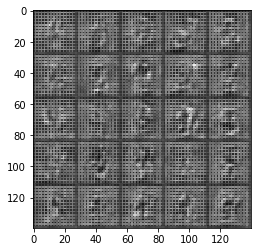

Step: 301
Step: 302
Step: 303
Step: 304
Step: 305
Step: 306
Step: 307
Step: 308
Step: 309
Step: 310
Epoch 310/2... Discriminator Loss: 0.2385... Generator Loss: 1.9825
Step: 311
Step: 312
Step: 313
Step: 314
Step: 315
Step: 316
Step: 317
Step: 318
Step: 319
Step: 320
Epoch 320/2... Discriminator Loss: 0.5403... Generator Loss: 1.1144
Step: 321
Step: 322
Step: 323
Step: 324
Step: 325
Step: 326
Step: 327
Step: 328
Step: 329
Step: 330
Epoch 330/2... Discriminator Loss: 0.3668... Generator Loss: 2.0976
Step: 331
Step: 332
Step: 333
Step: 334
Step: 335
Step: 336
Step: 337
Step: 338
Step: 339
Step: 340
Epoch 340/2... Discriminator Loss: 0.6942... Generator Loss: 1.0013
Step: 341
Step: 342
Step: 343
Step: 344
Step: 345
Step: 346
Step: 347
Step: 348
Step: 349
Step: 350
Epoch 350/2... Discriminator Loss: 0.6165... Generator Loss: 2.8008


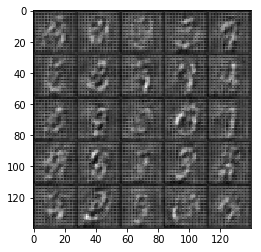

Step: 351
Step: 352
Step: 353
Step: 354
Step: 355
Step: 356
Step: 357
Step: 358
Step: 359
Step: 360
Epoch 360/2... Discriminator Loss: 0.7717... Generator Loss: 3.1430
Step: 361
Step: 362
Step: 363
Step: 364
Step: 365
Step: 366
Step: 367
Step: 368
Step: 369
Step: 370
Epoch 370/2... Discriminator Loss: 1.2266... Generator Loss: 0.4192
Step: 371
Step: 372
Step: 373
Step: 374
Step: 375
Step: 376
Step: 377
Step: 378
Step: 379
Step: 380
Epoch 380/2... Discriminator Loss: 0.3682... Generator Loss: 1.5790
Step: 381
Step: 382
Step: 383
Step: 384
Step: 385
Step: 386
Step: 387
Step: 388
Step: 389
Step: 390
Epoch 390/2... Discriminator Loss: 0.4021... Generator Loss: 1.3947
Step: 391
Step: 392
Step: 393
Step: 394
Step: 395
Step: 396
Step: 397
Step: 398
Step: 399
Step: 400
Epoch 400/2... Discriminator Loss: 0.3191... Generator Loss: 2.1869


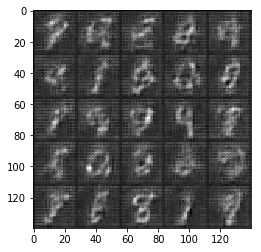

Step: 401
Step: 402
Step: 403
Step: 404
Step: 405
Step: 406
Step: 407
Step: 408
Step: 409
Step: 410
Epoch 410/2... Discriminator Loss: 0.6805... Generator Loss: 0.9386
Step: 411
Step: 412
Step: 413
Step: 414
Step: 415
Step: 416
Step: 417
Step: 418
Step: 419
Step: 420
Epoch 420/2... Discriminator Loss: 0.2784... Generator Loss: 2.2345
Step: 421
Step: 422
Step: 423
Step: 424
Step: 425
Step: 426
Step: 427
Step: 428
Step: 429
Step: 430
Epoch 430/2... Discriminator Loss: 0.7894... Generator Loss: 0.7356
Step: 431
Step: 432
Step: 433
Step: 434
Step: 435
Step: 436
Step: 437
Step: 438
Step: 439
Step: 440
Epoch 440/2... Discriminator Loss: 0.2166... Generator Loss: 2.2365
Step: 441
Step: 442
Step: 443
Step: 444
Step: 445
Step: 446
Step: 447
Step: 448
Step: 449
Step: 450
Epoch 450/2... Discriminator Loss: 0.2354... Generator Loss: 2.4819


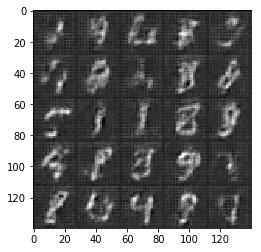

Step: 451
Step: 452
Step: 453
Step: 454
Step: 455
Step: 456
Step: 457
Step: 458
Step: 459
Step: 460
Epoch 460/2... Discriminator Loss: 0.6030... Generator Loss: 1.8414
Step: 461
Step: 462
Step: 463
Step: 464
Step: 465
Step: 466
Step: 467
Step: 468
Step: 469
Step: 470
Epoch 470/2... Discriminator Loss: 0.3213... Generator Loss: 1.9092
Step: 471
Step: 472
Step: 473
Step: 474
Step: 475
Step: 476
Step: 477
Step: 478
Step: 479
Step: 480
Epoch 480/2... Discriminator Loss: 0.4256... Generator Loss: 1.5052
Step: 481
Step: 482
Step: 483
Step: 484
Step: 485
Step: 486
Step: 487
Step: 488
Step: 489
Step: 490
Epoch 490/2... Discriminator Loss: 0.2584... Generator Loss: 1.9230
Step: 491
Step: 492
Step: 493
Step: 494
Step: 495
Step: 496
Step: 497
Step: 498
Step: 499
Step: 500
Epoch 500/2... Discriminator Loss: 0.3245... Generator Loss: 1.9717


Step: 501
Step: 502
Step: 503
Step: 504
Step: 505
Step: 506
Step: 507
Step: 508
Step: 509
Step: 510
Epoch 510/2... Discriminator Loss: 0.2921... Generator Loss: 1.9408
Step: 511
Step: 512
Step: 513
Step: 514
Step: 515
Step: 516
Step: 517
Step: 518
Step: 519
Step: 520
Epoch 520/2... Discriminator Loss: 0.6412... Generator Loss: 1.0128
Step: 521
Step: 522
Step: 523
Step: 524
Step: 525
Step: 526
Step: 527
Step: 528
Step: 529
Step: 530
Epoch 530/2... Discriminator Loss: 0.2285... Generator Loss: 2.1753
Step: 531
Step: 532
Step: 533
Step: 534
Step: 535
Step: 536
Step: 537
Step: 538
Step: 539
Step: 540
Epoch 540/2... Discriminator Loss: 0.3176... Generator Loss: 1.6690
Step: 541
Step: 542
Step: 543
Step: 544
Step: 545
Step: 546
Step: 547
Step: 548
Step: 549
Step: 550
Epoch 550/2... Discriminator Loss: 0.2437... Generator Loss: 2.2828


Step: 551
Step: 552
Step: 553
Step: 554
Step: 555
Step: 556
Step: 557
Step: 558
Step: 559
Step: 560
Epoch 560/2... Discriminator Loss: 0.3745... Generator Loss: 1.5031
Step: 561
Step: 562
Step: 563
Step: 564
Step: 565
Step: 566
Step: 567
Step: 568
Step: 569
Step: 570
Epoch 570/2... Discriminator Loss: 1.7902... Generator Loss: 0.2554
Step: 571
Step: 572
Step: 573
Step: 574
Step: 575
Step: 576
Step: 577
Step: 578
Step: 579
Step: 580
Epoch 580/2... Discriminator Loss: 0.4683... Generator Loss: 1.3163
Step: 581
Step: 582
Step: 583
Step: 584
Step: 585
Step: 586
Step: 587
Step: 588
Step: 589
Step: 590
Epoch 590/2... Discriminator Loss: 0.3740... Generator Loss: 1.5205
Step: 591
Step: 592
Step: 593
Step: 594
Step: 595
Step: 596
Step: 597
Step: 598
Step: 599
Step: 600
Epoch 600/2... Discriminator Loss: 0.4890... Generator Loss: 1.2578


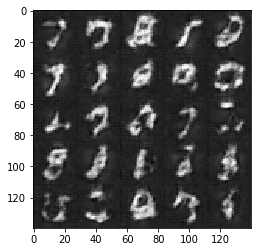

Step: 601
Step: 602
Step: 603
Step: 604
Step: 605
Step: 606
Step: 607
Step: 608
Step: 609
Step: 610
Epoch 610/2... Discriminator Loss: 0.2842... Generator Loss: 2.1460
Step: 611
Step: 612
Step: 613
Step: 614
Step: 615
Step: 616
Step: 617
Step: 618
Step: 619
Step: 620
Epoch 620/2... Discriminator Loss: 0.1439... Generator Loss: 2.5721
Step: 621
Step: 622
Step: 623
Step: 624
Step: 625
Step: 626
Step: 627
Step: 628
Step: 629
Step: 630
Epoch 630/2... Discriminator Loss: 0.2524... Generator Loss: 2.0188
Step: 631
Step: 632
Step: 633
Step: 634
Step: 635
Step: 636
Step: 637
Step: 638
Step: 639
Step: 640
Epoch 640/2... Discriminator Loss: 1.6360... Generator Loss: 2.2358
Step: 641
Step: 642
Step: 643
Step: 644
Step: 645
Step: 646
Step: 647
Step: 648
Step: 649
Step: 650
Epoch 650/2... Discriminator Loss: 0.9809... Generator Loss: 2.1485


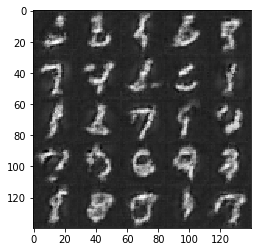

Step: 651
Step: 652
Step: 653
Step: 654
Step: 655
Step: 656
Step: 657
Step: 658
Step: 659
Step: 660
Epoch 660/2... Discriminator Loss: 0.6398... Generator Loss: 1.3977
Step: 661
Step: 662
Step: 663
Step: 664
Step: 665
Step: 666
Step: 667
Step: 668
Step: 669
Step: 670
Epoch 670/2... Discriminator Loss: 0.5067... Generator Loss: 1.4093
Step: 671
Step: 672
Step: 673
Step: 674
Step: 675
Step: 676
Step: 677
Step: 678
Step: 679
Step: 680
Epoch 680/2... Discriminator Loss: 0.5788... Generator Loss: 1.0979
Step: 681
Step: 682
Step: 683
Step: 684
Step: 685
Step: 686
Step: 687
Step: 688
Step: 689
Step: 690
Epoch 690/2... Discriminator Loss: 0.3279... Generator Loss: 1.7344
Step: 691
Step: 692
Step: 693
Step: 694
Step: 695
Step: 696
Step: 697
Step: 698
Step: 699
Step: 700
Epoch 700/2... Discriminator Loss: 0.4679... Generator Loss: 1.2338


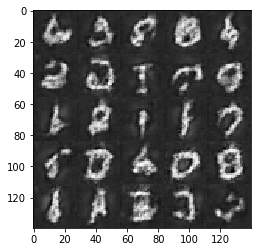

Step: 701
Step: 702
Step: 703
Step: 704
Step: 705
Step: 706
Step: 707
Step: 708
Step: 709
Step: 710
Epoch 710/2... Discriminator Loss: 0.4916... Generator Loss: 1.1812
Step: 711
Step: 712
Step: 713
Step: 714
Step: 715
Step: 716
Step: 717
Step: 718
Step: 719
Step: 720
Epoch 720/2... Discriminator Loss: 0.2386... Generator Loss: 2.6766
Step: 721
Step: 722
Step: 723
Step: 724
Step: 725
Step: 726
Step: 727
Step: 728
Step: 729
Step: 730
Epoch 730/2... Discriminator Loss: 0.3285... Generator Loss: 1.6335
Step: 731
Step: 732
Step: 733
Step: 734
Step: 735
Step: 736
Step: 737
Step: 738
Step: 739
Step: 740
Epoch 740/2... Discriminator Loss: 0.1831... Generator Loss: 3.3151
Step: 741
Step: 742
Step: 743
Step: 744
Step: 745
Step: 746
Step: 747
Step: 748
Step: 749
Step: 750
Epoch 750/2... Discriminator Loss: 0.2280... Generator Loss: 2.0121


Step: 751
Step: 752
Step: 753
Step: 754
Step: 755
Step: 756
Step: 757
Step: 758
Step: 759
Step: 760
Epoch 760/2... Discriminator Loss: 0.2430... Generator Loss: 2.0533
Step: 761
Step: 762
Step: 763
Step: 764
Step: 765
Step: 766
Step: 767
Step: 768
Step: 769
Step: 770
Epoch 770/2... Discriminator Loss: 0.1779... Generator Loss: 2.1625
Step: 771
Step: 772
Step: 773
Step: 774
Step: 775
Step: 776
Step: 777
Step: 778
Step: 779
Step: 780
Epoch 780/2... Discriminator Loss: 0.4874... Generator Loss: 1.4307
Step: 781
Step: 782
Step: 783
Step: 784
Step: 785
Step: 786
Step: 787
Step: 788
Step: 789
Step: 790
Epoch 790/2... Discriminator Loss: 0.6409... Generator Loss: 0.8984
Step: 791
Step: 792
Step: 793
Step: 794
Step: 795
Step: 796
Step: 797
Step: 798
Step: 799
Step: 800
Epoch 800/2... Discriminator Loss: 0.2334... Generator Loss: 2.0434


Step: 801
Step: 802
Step: 803
Step: 804
Step: 805
Step: 806
Step: 807
Step: 808
Step: 809
Step: 810
Epoch 810/2... Discriminator Loss: 1.1110... Generator Loss: 0.5133
Step: 811
Step: 812
Step: 813
Step: 814
Step: 815
Step: 816
Step: 817
Step: 818
Step: 819
Step: 820
Epoch 820/2... Discriminator Loss: 0.2022... Generator Loss: 3.0669
Step: 821
Step: 822
Step: 823
Step: 824
Step: 825
Step: 826
Step: 827
Step: 828
Step: 829
Step: 830
Epoch 830/2... Discriminator Loss: 0.4009... Generator Loss: 1.3439
Step: 831
Step: 832
Step: 833
Step: 834
Step: 835
Step: 836
Step: 837
Step: 838
Step: 839
Step: 840
Epoch 840/2... Discriminator Loss: 0.2596... Generator Loss: 1.8986
Step: 841
Step: 842
Step: 843
Step: 844
Step: 845
Step: 846
Step: 847
Step: 848
Step: 849
Step: 850
Epoch 850/2... Discriminator Loss: 0.4260... Generator Loss: 1.3296


Step: 851
Step: 852
Step: 853
Step: 854
Step: 855
Step: 856
Step: 857
Step: 858
Step: 859
Step: 860
Epoch 860/2... Discriminator Loss: 2.2413... Generator Loss: 0.1981
Step: 861
Step: 862
Step: 863
Step: 864
Step: 865
Step: 866
Step: 867
Step: 868
Step: 869
Step: 870
Epoch 870/2... Discriminator Loss: 0.4857... Generator Loss: 1.2882
Step: 871
Step: 872
Step: 873
Step: 874
Step: 875
Step: 876
Step: 877
Step: 878
Step: 879
Step: 880
Epoch 880/2... Discriminator Loss: 0.2073... Generator Loss: 2.2357
Step: 881
Step: 882
Step: 883
Step: 884
Step: 885
Step: 886
Step: 887
Step: 888
Step: 889
Step: 890
Epoch 890/2... Discriminator Loss: 0.1796... Generator Loss: 2.2830
Step: 891
Step: 892
Step: 893
Step: 894
Step: 895
Step: 896
Step: 897
Step: 898
Step: 899
Step: 900
Epoch 900/2... Discriminator Loss: 1.8219... Generator Loss: 0.3469


Step: 901
Step: 902
Step: 903
Step: 904
Step: 905
Step: 906
Step: 907
Step: 908
Step: 909
Step: 910
Epoch 910/2... Discriminator Loss: 0.6111... Generator Loss: 1.0699
Step: 911
Step: 912
Step: 913
Step: 914
Step: 915
Step: 916
Step: 917
Step: 918
Step: 919
Step: 920
Epoch 920/2... Discriminator Loss: 0.4096... Generator Loss: 1.5461
Step: 921
Step: 922
Step: 923
Step: 924
Step: 925
Step: 926
Step: 927
Step: 928
Step: 929
Step: 930
Epoch 930/2... Discriminator Loss: 0.4260... Generator Loss: 1.2912
Step: 931
Step: 932
Step: 933
Step: 934
Step: 935
Step: 936
Step: 937
Step: 938
Step: 939
Step: 940
Epoch 940/2... Discriminator Loss: 0.7189... Generator Loss: 0.8806
Step: 941
Step: 942
Step: 943
Step: 944
Step: 945
Step: 946
Step: 947
Step: 948
Step: 949
Step: 950
Epoch 950/2... Discriminator Loss: 0.2823... Generator Loss: 1.7056


Step: 951
Step: 952
Step: 953
Step: 954
Step: 955
Step: 956
Step: 957
Step: 958
Step: 959
Step: 960
Epoch 960/2... Discriminator Loss: 0.3272... Generator Loss: 1.5662
Step: 961
Step: 962
Step: 963
Step: 964
Step: 965
Step: 966
Step: 967
Step: 968
Step: 969
Step: 970
Epoch 970/2... Discriminator Loss: 0.2847... Generator Loss: 1.7428
Step: 971
Step: 972
Step: 973
Step: 974
Step: 975
Step: 976
Step: 977
Step: 978
Step: 979
Step: 980
Epoch 980/2... Discriminator Loss: 0.1787... Generator Loss: 2.1408
Step: 981
Step: 982
Step: 983
Step: 984
Step: 985
Step: 986
Step: 987
Step: 988
Step: 989
Step: 990
Epoch 990/2... Discriminator Loss: 0.3225... Generator Loss: 1.5406
Step: 991
Step: 992
Step: 993
Step: 994
Step: 995
Step: 996
Step: 997
Step: 998
Step: 999
Step: 1000
Epoch 1000/2... Discriminator Loss: 0.0632... Generator Loss: 3.6656


Step: 1001
Step: 1002
Step: 1003
Step: 1004
Step: 1005
Step: 1006
Step: 1007
Step: 1008
Step: 1009
Step: 1010
Epoch 1010/2... Discriminator Loss: 1.3490... Generator Loss: 0.4673
Step: 1011
Step: 1012
Step: 1013
Step: 1014
Step: 1015
Step: 1016
Step: 1017
Step: 1018
Step: 1019
Step: 1020
Epoch 1020/2... Discriminator Loss: 0.5631... Generator Loss: 1.7125
Step: 1021
Step: 1022
Step: 1023
Step: 1024
Step: 1025
Step: 1026
Step: 1027
Step: 1028
Step: 1029
Step: 1030
Epoch 1030/2... Discriminator Loss: 1.1268... Generator Loss: 3.1696
Step: 1031
Step: 1032
Step: 1033
Step: 1034
Step: 1035
Step: 1036
Step: 1037
Step: 1038
Step: 1039
Step: 1040
Epoch 1040/2... Discriminator Loss: 0.4827... Generator Loss: 1.4601
Step: 1041
Step: 1042
Step: 1043
Step: 1044
Step: 1045
Step: 1046
Step: 1047
Step: 1048
Step: 1049
Step: 1050
Epoch 1050/2... Discriminator Loss: 1.1985... Generator Loss: 0.5319


Step: 1051
Step: 1052
Step: 1053
Step: 1054
Step: 1055
Step: 1056
Step: 1057
Step: 1058
Step: 1059
Step: 1060
Epoch 1060/2... Discriminator Loss: 0.4312... Generator Loss: 1.4233
Step: 1061
Step: 1062
Step: 1063
Step: 1064
Step: 1065
Step: 1066
Step: 1067
Step: 1068
Step: 1069
Step: 1070
Epoch 1070/2... Discriminator Loss: 0.5903... Generator Loss: 1.0800
Step: 1071
Step: 1072
Step: 1073
Step: 1074
Step: 1075
Step: 1076
Step: 1077
Step: 1078
Step: 1079
Step: 1080
Epoch 1080/2... Discriminator Loss: 0.4399... Generator Loss: 1.4354
Step: 1081
Step: 1082
Step: 1083
Step: 1084
Step: 1085
Step: 1086
Step: 1087
Step: 1088
Step: 1089
Step: 1090
Epoch 1090/2... Discriminator Loss: 0.3540... Generator Loss: 1.6871
Step: 1091
Step: 1092
Step: 1093
Step: 1094
Step: 1095
Step: 1096
Step: 1097
Step: 1098
Step: 1099
Step: 1100
Epoch 1100/2... Discriminator Loss: 0.2284... Generator Loss: 2.1162


Step: 1101
Step: 1102
Step: 1103
Step: 1104
Step: 1105
Step: 1106
Step: 1107
Step: 1108
Step: 1109
Step: 1110
Epoch 1110/2... Discriminator Loss: 1.4262... Generator Loss: 0.3703
Step: 1111
Step: 1112
Step: 1113
Step: 1114
Step: 1115
Step: 1116
Step: 1117
Step: 1118
Step: 1119
Step: 1120
Epoch 1120/2... Discriminator Loss: 0.1679... Generator Loss: 3.5414
Step: 1121
Step: 1122
Step: 1123
Step: 1124
Step: 1125
Step: 1126
Step: 1127
Step: 1128
Step: 1129
Step: 1130
Epoch 1130/2... Discriminator Loss: 0.1501... Generator Loss: 2.7839
Step: 1131
Step: 1132
Step: 1133
Step: 1134
Step: 1135
Step: 1136
Step: 1137
Step: 1138
Step: 1139
Step: 1140
Epoch 1140/2... Discriminator Loss: 0.1449... Generator Loss: 2.4894
Step: 1141
Step: 1142
Step: 1143
Step: 1144
Step: 1145
Step: 1146
Step: 1147
Step: 1148
Step: 1149
Step: 1150
Epoch 1150/2... Discriminator Loss: 0.1473... Generator Loss: 2.4420


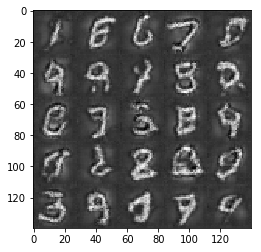

Step: 1151
Step: 1152
Step: 1153
Step: 1154
Step: 1155
Step: 1156
Step: 1157
Step: 1158
Step: 1159
Step: 1160
Epoch 1160/2... Discriminator Loss: 0.0706... Generator Loss: 3.4408
Step: 1161
Step: 1162
Step: 1163
Step: 1164
Step: 1165
Step: 1166
Step: 1167
Step: 1168
Step: 1169
Step: 1170
Epoch 1170/2... Discriminator Loss: 0.0578... Generator Loss: 4.0918
Step: 1171
Step: 1172
Step: 1173
Step: 1174
Step: 1175
Step: 1176
Step: 1177
Step: 1178
Step: 1179
Step: 1180
Epoch 1180/2... Discriminator Loss: 0.0757... Generator Loss: 3.2762
Step: 1181
Step: 1182
Step: 1183
Step: 1184
Step: 1185
Step: 1186
Step: 1187
Step: 1188
Step: 1189
Step: 1190
Epoch 1190/2... Discriminator Loss: 0.3501... Generator Loss: 1.4670
Step: 1191
Step: 1192
Step: 1193
Step: 1194
Step: 1195
Step: 1196
Step: 1197
Step: 1198
Step: 1199
Step: 1200
Epoch 1200/2... Discriminator Loss: 0.1298... Generator Loss: 3.4237


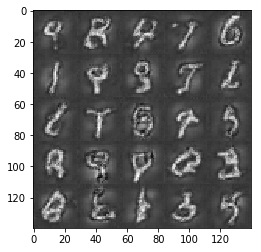

Step: 1201
Step: 1202
Step: 1203
Step: 1204
Step: 1205
Step: 1206
Step: 1207
Step: 1208
Step: 1209
Step: 1210
Epoch 1210/2... Discriminator Loss: 0.0627... Generator Loss: 3.6014
Step: 1211
Step: 1212
Step: 1213
Step: 1214
Step: 1215
Step: 1216
Step: 1217
Step: 1218
Step: 1219
Step: 1220
Epoch 1220/2... Discriminator Loss: 0.1148... Generator Loss: 3.4657
Step: 1221
Step: 1222
Step: 1223
Step: 1224
Step: 1225
Step: 1226
Step: 1227
Step: 1228
Step: 1229
Step: 1230
Epoch 1230/2... Discriminator Loss: 0.1026... Generator Loss: 4.5759
Step: 1231
Step: 1232
Step: 1233
Step: 1234
Step: 1235
Step: 1236
Step: 1237
Step: 1238
Step: 1239
Step: 1240
Epoch 1240/2... Discriminator Loss: 2.1204... Generator Loss: 5.3196
Step: 1241
Step: 1242
Step: 1243
Step: 1244
Step: 1245
Step: 1246
Step: 1247
Step: 1248
Step: 1249
Step: 1250
Epoch 1250/2... Discriminator Loss: 1.0180... Generator Loss: 1.1461


Step: 1251
Step: 1252
Step: 1253
Step: 1254
Step: 1255
Step: 1256
Step: 1257
Step: 1258
Step: 1259
Step: 1260
Epoch 1260/2... Discriminator Loss: 0.3897... Generator Loss: 2.8610
Step: 1261
Step: 1262
Step: 1263
Step: 1264
Step: 1265
Step: 1266
Step: 1267
Step: 1268
Step: 1269
Step: 1270
Epoch 1270/2... Discriminator Loss: 0.4927... Generator Loss: 1.4043
Step: 1271
Step: 1272
Step: 1273
Step: 1274
Step: 1275
Step: 1276
Step: 1277
Step: 1278
Step: 1279
Step: 1280
Epoch 1280/2... Discriminator Loss: 0.7894... Generator Loss: 0.9795
Step: 1281
Step: 1282
Step: 1283
Step: 1284
Step: 1285
Step: 1286
Step: 1287
Step: 1288
Step: 1289
Step: 1290
Epoch 1290/2... Discriminator Loss: 0.7067... Generator Loss: 0.9250
Step: 1291
Step: 1292
Step: 1293
Step: 1294
Step: 1295
Step: 1296
Step: 1297
Step: 1298
Step: 1299
Step: 1300
Epoch 1300/2... Discriminator Loss: 0.3961... Generator Loss: 1.5468


Step: 1301
Step: 1302
Step: 1303
Step: 1304
Step: 1305
Step: 1306
Step: 1307
Step: 1308
Step: 1309
Step: 1310
Epoch 1310/2... Discriminator Loss: 0.3977... Generator Loss: 1.5633
Step: 1311
Step: 1312
Step: 1313
Step: 1314
Step: 1315
Step: 1316
Step: 1317
Step: 1318
Step: 1319
Step: 1320
Epoch 1320/2... Discriminator Loss: 0.2032... Generator Loss: 2.5600
Step: 1321
Step: 1322
Step: 1323
Step: 1324
Step: 1325
Step: 1326
Step: 1327
Step: 1328
Step: 1329
Step: 1330
Epoch 1330/2... Discriminator Loss: 0.5940... Generator Loss: 1.1254
Step: 1331
Step: 1332
Step: 1333
Step: 1334
Step: 1335
Step: 1336
Step: 1337
Step: 1338
Step: 1339
Step: 1340
Epoch 1340/2... Discriminator Loss: 0.1186... Generator Loss: 2.7986
Step: 1341
Step: 1342
Step: 1343
Step: 1344
Step: 1345
Step: 1346
Step: 1347
Step: 1348
Step: 1349
Step: 1350
Epoch 1350/2... Discriminator Loss: 0.7548... Generator Loss: 0.9071


Step: 1351
Step: 1352
Step: 1353
Step: 1354
Step: 1355
Step: 1356
Step: 1357
Step: 1358
Step: 1359
Step: 1360
Epoch 1360/2... Discriminator Loss: 0.0619... Generator Loss: 3.3476
Step: 1361
Step: 1362
Step: 1363
Step: 1364
Step: 1365
Step: 1366
Step: 1367
Step: 1368
Step: 1369
Step: 1370
Epoch 1370/2... Discriminator Loss: 0.3324... Generator Loss: 1.5835
Step: 1371
Step: 1372
Step: 1373
Step: 1374
Step: 1375
Step: 1376
Step: 1377
Step: 1378
Step: 1379
Step: 1380
Epoch 1380/2... Discriminator Loss: 0.5225... Generator Loss: 1.1580
Step: 1381
Step: 1382
Step: 1383
Step: 1384
Step: 1385
Step: 1386
Step: 1387
Step: 1388
Step: 1389
Step: 1390
Epoch 1390/2... Discriminator Loss: 0.6224... Generator Loss: 1.1976
Step: 1391
Step: 1392
Step: 1393
Step: 1394
Step: 1395
Step: 1396
Step: 1397
Step: 1398
Step: 1399
Step: 1400
Epoch 1400/2... Discriminator Loss: 0.2076... Generator Loss: 2.0696


Step: 1401
Step: 1402
Step: 1403
Step: 1404
Step: 1405
Step: 1406
Step: 1407
Step: 1408
Step: 1409
Step: 1410
Epoch 1410/2... Discriminator Loss: 0.1026... Generator Loss: 2.9931
Step: 1411
Step: 1412
Step: 1413
Step: 1414
Step: 1415
Step: 1416
Step: 1417
Step: 1418
Step: 1419
Step: 1420
Epoch 1420/2... Discriminator Loss: 0.2269... Generator Loss: 3.7437
Step: 1421
Step: 1422
Step: 1423
Step: 1424
Step: 1425
Step: 1426
Step: 1427
Step: 1428
Step: 1429
Step: 1430
Epoch 1430/2... Discriminator Loss: 0.7887... Generator Loss: 0.9170
Step: 1431
Step: 1432
Step: 1433
Step: 1434
Step: 1435
Step: 1436
Step: 1437
Step: 1438
Step: 1439
Step: 1440
Epoch 1440/2... Discriminator Loss: 2.8243... Generator Loss: 6.4282
Step: 1441
Step: 1442
Step: 1443
Step: 1444
Step: 1445
Step: 1446
Step: 1447
Step: 1448
Step: 1449
Step: 1450
Epoch 1450/2... Discriminator Loss: 0.7330... Generator Loss: 1.0514


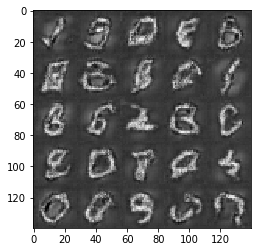

Step: 1451
Step: 1452
Step: 1453
Step: 1454
Step: 1455
Step: 1456
Step: 1457
Step: 1458
Step: 1459
Step: 1460
Epoch 1460/2... Discriminator Loss: 0.6279... Generator Loss: 1.0730
Step: 1461
Step: 1462
Step: 1463
Step: 1464
Step: 1465
Step: 1466
Step: 1467
Step: 1468
Step: 1469
Step: 1470
Epoch 1470/2... Discriminator Loss: 0.4348... Generator Loss: 2.2160
Step: 1471
Step: 1472
Step: 1473
Step: 1474
Step: 1475
Step: 1476
Step: 1477
Step: 1478
Step: 1479
Step: 1480
Epoch 1480/2... Discriminator Loss: 1.0864... Generator Loss: 0.5855
Step: 1481
Step: 1482
Step: 1483
Step: 1484
Step: 1485
Step: 1486
Step: 1487
Step: 1488
Step: 1489
Step: 1490
Epoch 1490/2... Discriminator Loss: 0.2995... Generator Loss: 2.2970
Step: 1491
Step: 1492
Step: 1493
Step: 1494
Step: 1495
Step: 1496
Step: 1497
Step: 1498
Step: 1499
Step: 1500
Epoch 1500/2... Discriminator Loss: 0.4012... Generator Loss: 1.5671


Step: 1501
Step: 1502
Step: 1503
Step: 1504
Step: 1505
Step: 1506
Step: 1507
Step: 1508
Step: 1509
Step: 1510
Epoch 1510/2... Discriminator Loss: 0.3386... Generator Loss: 3.5801
Step: 1511
Step: 1512
Step: 1513
Step: 1514
Step: 1515
Step: 1516
Step: 1517
Step: 1518
Step: 1519
Step: 1520
Epoch 1520/2... Discriminator Loss: 0.2447... Generator Loss: 1.9274
Step: 1521
Step: 1522
Step: 1523
Step: 1524
Step: 1525
Step: 1526
Step: 1527
Step: 1528
Step: 1529
Step: 1530
Epoch 1530/2... Discriminator Loss: 0.2755... Generator Loss: 1.7752
Step: 1531
Step: 1532
Step: 1533
Step: 1534
Step: 1535
Step: 1536
Step: 1537
Step: 1538
Step: 1539
Step: 1540
Epoch 1540/2... Discriminator Loss: 0.2843... Generator Loss: 1.7264
Step: 1541
Step: 1542
Step: 1543
Step: 1544
Step: 1545
Step: 1546
Step: 1547
Step: 1548
Step: 1549
Step: 1550
Epoch 1550/2... Discriminator Loss: 1.7520... Generator Loss: 0.2922


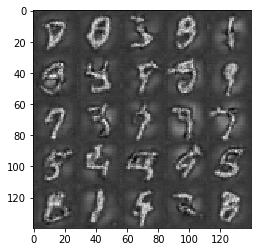

Step: 1551
Step: 1552
Step: 1553
Step: 1554
Step: 1555
Step: 1556
Step: 1557
Step: 1558
Step: 1559
Step: 1560
Epoch 1560/2... Discriminator Loss: 0.3984... Generator Loss: 1.9097
Step: 1561
Step: 1562
Step: 1563
Step: 1564
Step: 1565
Step: 1566
Step: 1567
Step: 1568
Step: 1569
Step: 1570
Epoch 1570/2... Discriminator Loss: 0.3341... Generator Loss: 1.6220
Step: 1571
Step: 1572
Step: 1573
Step: 1574
Step: 1575
Step: 1576
Step: 1577
Step: 1578
Step: 1579
Step: 1580
Epoch 1580/2... Discriminator Loss: 0.2567... Generator Loss: 2.1535
Step: 1581
Step: 1582
Step: 1583
Step: 1584
Step: 1585
Step: 1586
Step: 1587
Step: 1588
Step: 1589
Step: 1590
Epoch 1590/2... Discriminator Loss: 0.2657... Generator Loss: 1.7636
Step: 1591
Step: 1592
Step: 1593
Step: 1594
Step: 1595
Step: 1596
Step: 1597
Step: 1598
Step: 1599
Step: 1600
Epoch 1600/2... Discriminator Loss: 0.4041... Generator Loss: 3.6015


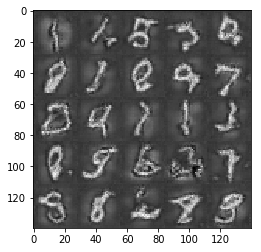

Step: 1601
Step: 1602
Step: 1603
Step: 1604
Step: 1605
Step: 1606
Step: 1607
Step: 1608
Step: 1609
Step: 1610
Epoch 1610/2... Discriminator Loss: 0.1333... Generator Loss: 2.6974
Step: 1611
Step: 1612
Step: 1613
Step: 1614
Step: 1615
Step: 1616
Step: 1617
Step: 1618
Step: 1619
Step: 1620
Epoch 1620/2... Discriminator Loss: 0.2122... Generator Loss: 2.0820
Step: 1621
Step: 1622
Step: 1623
Step: 1624
Step: 1625
Step: 1626
Step: 1627
Step: 1628
Step: 1629
Step: 1630
Epoch 1630/2... Discriminator Loss: 0.2418... Generator Loss: 1.8810
Step: 1631
Step: 1632
Step: 1633
Step: 1634
Step: 1635
Step: 1636
Step: 1637
Step: 1638
Step: 1639
Step: 1640
Epoch 1640/2... Discriminator Loss: 0.2341... Generator Loss: 1.9231
Step: 1641
Step: 1642
Step: 1643
Step: 1644
Step: 1645
Step: 1646
Step: 1647
Step: 1648
Step: 1649
Step: 1650
Epoch 1650/2... Discriminator Loss: 0.0246... Generator Loss: 4.9453


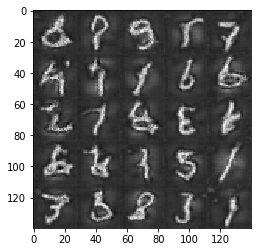

Step: 1651
Step: 1652
Step: 1653
Step: 1654
Step: 1655
Step: 1656
Step: 1657
Step: 1658
Step: 1659
Step: 1660
Epoch 1660/2... Discriminator Loss: 0.0612... Generator Loss: 4.5127
Step: 1661
Step: 1662
Step: 1663
Step: 1664
Step: 1665
Step: 1666
Step: 1667
Step: 1668
Step: 1669
Step: 1670
Epoch 1670/2... Discriminator Loss: 0.0849... Generator Loss: 3.3973
Step: 1671
Step: 1672
Step: 1673
Step: 1674
Step: 1675
Step: 1676
Step: 1677
Step: 1678
Step: 1679
Step: 1680
Epoch 1680/2... Discriminator Loss: 0.3249... Generator Loss: 1.5729
Step: 1681
Step: 1682
Step: 1683
Step: 1684
Step: 1685
Step: 1686
Step: 1687
Step: 1688
Step: 1689
Step: 1690
Epoch 1690/2... Discriminator Loss: 0.0686... Generator Loss: 3.2294
Step: 1691
Step: 1692
Step: 1693
Step: 1694
Step: 1695
Step: 1696
Step: 1697
Step: 1698
Step: 1699
Step: 1700
Epoch 1700/2... Discriminator Loss: 0.1747... Generator Loss: 2.1515


Step: 1701
Step: 1702
Step: 1703
Step: 1704
Step: 1705
Step: 1706
Step: 1707
Step: 1708
Step: 1709
Step: 1710
Epoch 1710/2... Discriminator Loss: 0.0759... Generator Loss: 4.3621
Step: 1711
Step: 1712
Step: 1713
Step: 1714
Step: 1715
Step: 1716
Step: 1717
Step: 1718
Step: 1719
Step: 1720
Epoch 1720/2... Discriminator Loss: 0.1500... Generator Loss: 2.3073
Step: 1721
Step: 1722
Step: 1723
Step: 1724
Step: 1725
Step: 1726
Step: 1727
Step: 1728
Step: 1729
Step: 1730
Epoch 1730/2... Discriminator Loss: 5.4588... Generator Loss: 11.1032
Step: 1731
Step: 1732
Step: 1733
Step: 1734
Step: 1735
Step: 1736
Step: 1737
Step: 1738
Step: 1739
Step: 1740
Epoch 1740/2... Discriminator Loss: 0.3513... Generator Loss: 1.8283
Step: 1741
Step: 1742
Step: 1743
Step: 1744
Step: 1745
Step: 1746
Step: 1747
Step: 1748
Step: 1749
Step: 1750
Epoch 1750/2... Discriminator Loss: 0.2633... Generator Loss: 2.0111


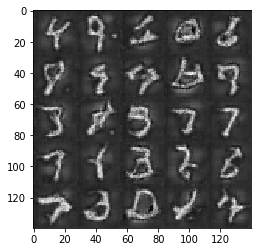

Step: 1751
Step: 1752
Step: 1753
Step: 1754
Step: 1755
Step: 1756
Step: 1757
Step: 1758
Step: 1759
Step: 1760
Epoch 1760/2... Discriminator Loss: 0.2681... Generator Loss: 1.8650
Step: 1761
Step: 1762
Step: 1763
Step: 1764
Step: 1765
Step: 1766
Step: 1767
Step: 1768
Step: 1769
Step: 1770
Epoch 1770/2... Discriminator Loss: 0.2086... Generator Loss: 2.2867
Step: 1771
Step: 1772
Step: 1773
Step: 1774
Step: 1775
Step: 1776
Step: 1777
Step: 1778
Step: 1779
Step: 1780
Epoch 1780/2... Discriminator Loss: 0.2165... Generator Loss: 2.1288
Step: 1781
Step: 1782
Step: 1783
Step: 1784
Step: 1785
Step: 1786
Step: 1787
Step: 1788
Step: 1789
Step: 1790
Epoch 1790/2... Discriminator Loss: 0.1715... Generator Loss: 2.1666
Step: 1791
Step: 1792
Step: 1793
Step: 1794
Step: 1795
Step: 1796
Step: 1797
Step: 1798
Step: 1799
Step: 1800
Epoch 1800/2... Discriminator Loss: 0.1619... Generator Loss: 2.2587


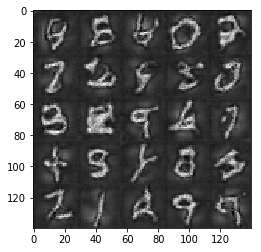

Step: 1801
Step: 1802
Step: 1803
Step: 1804
Step: 1805
Step: 1806
Step: 1807
Step: 1808
Step: 1809
Step: 1810
Epoch 1810/2... Discriminator Loss: 1.0925... Generator Loss: 0.7456
Step: 1811
Step: 1812
Step: 1813
Step: 1814
Step: 1815
Step: 1816
Step: 1817
Step: 1818
Step: 1819
Step: 1820
Epoch 1820/2... Discriminator Loss: 0.1834... Generator Loss: 2.1824
Step: 1821
Step: 1822
Step: 1823
Step: 1824
Step: 1825
Step: 1826
Step: 1827
Step: 1828
Step: 1829
Step: 1830
Epoch 1830/2... Discriminator Loss: 0.2156... Generator Loss: 1.9942
Step: 1831
Step: 1832
Step: 1833
Step: 1834
Step: 1835
Step: 1836
Step: 1837
Step: 1838
Step: 1839
Step: 1840
Epoch 1840/2... Discriminator Loss: 0.0457... Generator Loss: 4.3737
Step: 1841
Step: 1842
Step: 1843
Step: 1844
Step: 1845
Step: 1846
Step: 1847
Step: 1848
Step: 1849
Step: 1850
Epoch 1850/2... Discriminator Loss: 0.0422... Generator Loss: 4.5313


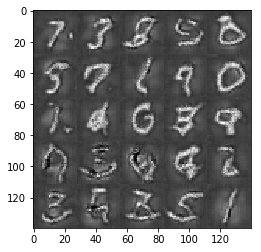

Step: 1851
Step: 1852
Step: 1853
Step: 1854
Step: 1855
Step: 1856
Step: 1857
Step: 1858
Step: 1859
Step: 1860
Epoch 1860/2... Discriminator Loss: 0.0589... Generator Loss: 4.0733
Step: 1861
Step: 1862
Step: 1863
Step: 1864
Step: 1865
Step: 1866
Step: 1867
Step: 1868
Step: 1869
Step: 1870
Epoch 1870/2... Discriminator Loss: 0.3742... Generator Loss: 1.4426
Step: 1871
Step: 1872
Step: 1873
Step: 1874


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Epoch 10/1... Discriminator Loss: 2.8154... Generator Loss: 0.1001
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Epoch 20/1... Discriminator Loss: 1.2780... Generator Loss: 0.5139
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Epoch 30/1... Discriminator Loss: 0.8388... Generator Loss: 0.9166
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Epoch 40/1... Discriminator Loss: 0.2079... Generator Loss: 2.1570
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Epoch 50/1... Discriminator Loss: 0.2026... Generator Loss: 2.6227


Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Epoch 60/1... Discriminator Loss: 0.1628... Generator Loss: 3.1325
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Epoch 70/1... Discriminator Loss: 0.6298... Generator Loss: 1.5160
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Epoch 80/1... Discriminator Loss: 0.5711... Generator Loss: 1.3977
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Epoch 90/1... Discriminator Loss: 0.1232... Generator Loss: 4.1856
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Epoch 100/1... Discriminator Loss: 2.4123... Generator Loss: 1.4427


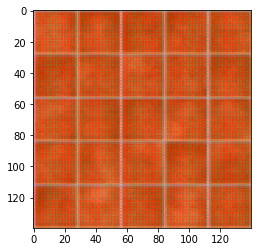

Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110
Epoch 110/1... Discriminator Loss: 0.4631... Generator Loss: 1.7123
Step: 111
Step: 112
Step: 113
Step: 114
Step: 115
Step: 116
Step: 117
Step: 118
Step: 119
Step: 120
Epoch 120/1... Discriminator Loss: 0.1078... Generator Loss: 3.6451
Step: 121
Step: 122
Step: 123
Step: 124
Step: 125
Step: 126
Step: 127
Step: 128
Step: 129
Step: 130
Epoch 130/1... Discriminator Loss: 2.0123... Generator Loss: 0.5752
Step: 131
Step: 132
Step: 133
Step: 134
Step: 135
Step: 136
Step: 137
Step: 138
Step: 139
Step: 140
Epoch 140/1... Discriminator Loss: 0.4222... Generator Loss: 2.0835
Step: 141
Step: 142
Step: 143
Step: 144
Step: 145
Step: 146
Step: 147
Step: 148
Step: 149
Step: 150
Epoch 150/1... Discriminator Loss: 0.0662... Generator Loss: 3.5948


Step: 151
Step: 152
Step: 153
Step: 154
Step: 155
Step: 156
Step: 157
Step: 158
Step: 159
Step: 160
Epoch 160/1... Discriminator Loss: 0.3753... Generator Loss: 1.6831
Step: 161
Step: 162
Step: 163
Step: 164
Step: 165
Step: 166
Step: 167
Step: 168
Step: 169
Step: 170
Epoch 170/1... Discriminator Loss: 1.7657... Generator Loss: 0.2983
Step: 171
Step: 172
Step: 173
Step: 174
Step: 175
Step: 176
Step: 177
Step: 178
Step: 179
Step: 180
Epoch 180/1... Discriminator Loss: 0.3521... Generator Loss: 3.9201
Step: 181
Step: 182
Step: 183
Step: 184
Step: 185
Step: 186
Step: 187
Step: 188
Step: 189
Step: 190
Epoch 190/1... Discriminator Loss: 1.2314... Generator Loss: 6.1916
Step: 191
Step: 192
Step: 193
Step: 194
Step: 195
Step: 196
Step: 197
Step: 198
Step: 199
Step: 200
Epoch 200/1... Discriminator Loss: 1.3787... Generator Loss: 0.4127


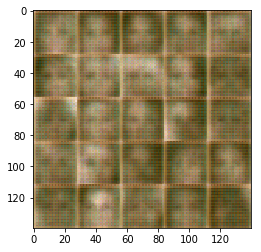

Step: 201
Step: 202
Step: 203
Step: 204
Step: 205
Step: 206
Step: 207
Step: 208
Step: 209
Step: 210
Epoch 210/1... Discriminator Loss: 0.6656... Generator Loss: 1.7236
Step: 211
Step: 212
Step: 213
Step: 214
Step: 215
Step: 216
Step: 217
Step: 218
Step: 219
Step: 220
Epoch 220/1... Discriminator Loss: 2.5948... Generator Loss: 0.1318
Step: 221
Step: 222
Step: 223
Step: 224
Step: 225
Step: 226
Step: 227
Step: 228
Step: 229
Step: 230
Epoch 230/1... Discriminator Loss: 1.0458... Generator Loss: 1.2654
Step: 231
Step: 232
Step: 233
Step: 234
Step: 235
Step: 236
Step: 237
Step: 238
Step: 239
Step: 240
Epoch 240/1... Discriminator Loss: 1.0088... Generator Loss: 0.9809
Step: 241
Step: 242
Step: 243
Step: 244
Step: 245
Step: 246
Step: 247
Step: 248
Step: 249
Step: 250
Epoch 250/1... Discriminator Loss: 1.1875... Generator Loss: 0.6785


Step: 251
Step: 252
Step: 253
Step: 254
Step: 255
Step: 256
Step: 257
Step: 258
Step: 259
Step: 260
Epoch 260/1... Discriminator Loss: 0.8679... Generator Loss: 1.6341
Step: 261
Step: 262
Step: 263
Step: 264
Step: 265
Step: 266
Step: 267
Step: 268
Step: 269
Step: 270
Epoch 270/1... Discriminator Loss: 1.4357... Generator Loss: 1.2551
Step: 271
Step: 272
Step: 273
Step: 274
Step: 275
Step: 276
Step: 277
Step: 278
Step: 279
Step: 280
Epoch 280/1... Discriminator Loss: 0.6789... Generator Loss: 1.3957
Step: 281
Step: 282
Step: 283
Step: 284
Step: 285
Step: 286
Step: 287
Step: 288
Step: 289
Step: 290
Epoch 290/1... Discriminator Loss: 2.0597... Generator Loss: 0.2026
Step: 291
Step: 292
Step: 293
Step: 294
Step: 295
Step: 296
Step: 297
Step: 298
Step: 299
Step: 300
Epoch 300/1... Discriminator Loss: 0.6237... Generator Loss: 1.4429


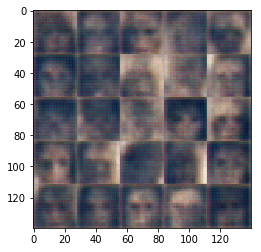

Step: 301
Step: 302
Step: 303
Step: 304
Step: 305
Step: 306
Step: 307
Step: 308
Step: 309
Step: 310
Epoch 310/1... Discriminator Loss: 1.4276... Generator Loss: 0.4697
Step: 311
Step: 312
Step: 313
Step: 314
Step: 315
Step: 316
Step: 317
Step: 318
Step: 319
Step: 320
Epoch 320/1... Discriminator Loss: 1.1085... Generator Loss: 0.6599
Step: 321
Step: 322
Step: 323
Step: 324
Step: 325
Step: 326
Step: 327
Step: 328
Step: 329
Step: 330
Epoch 330/1... Discriminator Loss: 1.2255... Generator Loss: 0.5248
Step: 331
Step: 332
Step: 333
Step: 334
Step: 335
Step: 336
Step: 337
Step: 338
Step: 339
Step: 340
Epoch 340/1... Discriminator Loss: 1.7929... Generator Loss: 0.3515
Step: 341
Step: 342
Step: 343
Step: 344
Step: 345
Step: 346
Step: 347
Step: 348
Step: 349
Step: 350
Epoch 350/1... Discriminator Loss: 2.6825... Generator Loss: 0.1338


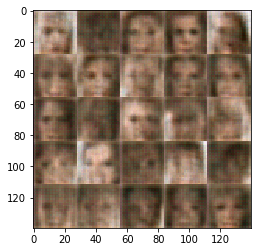

Step: 351
Step: 352
Step: 353
Step: 354
Step: 355
Step: 356
Step: 357
Step: 358
Step: 359
Step: 360
Epoch 360/1... Discriminator Loss: 0.9235... Generator Loss: 0.8580
Step: 361
Step: 362
Step: 363
Step: 364
Step: 365
Step: 366
Step: 367
Step: 368
Step: 369
Step: 370
Epoch 370/1... Discriminator Loss: 1.2172... Generator Loss: 0.5012
Step: 371
Step: 372
Step: 373
Step: 374
Step: 375
Step: 376
Step: 377
Step: 378
Step: 379
Step: 380
Epoch 380/1... Discriminator Loss: 0.9092... Generator Loss: 1.2920
Step: 381
Step: 382
Step: 383
Step: 384
Step: 385
Step: 386
Step: 387
Step: 388
Step: 389
Step: 390
Epoch 390/1... Discriminator Loss: 1.0436... Generator Loss: 0.8790
Step: 391
Step: 392
Step: 393
Step: 394
Step: 395
Step: 396
Step: 397
Step: 398
Step: 399
Step: 400
Epoch 400/1... Discriminator Loss: 1.6509... Generator Loss: 0.2898


Step: 401
Step: 402
Step: 403
Step: 404
Step: 405
Step: 406
Step: 407
Step: 408
Step: 409
Step: 410
Epoch 410/1... Discriminator Loss: 1.0763... Generator Loss: 0.8851
Step: 411
Step: 412
Step: 413
Step: 414
Step: 415
Step: 416
Step: 417
Step: 418
Step: 419
Step: 420
Epoch 420/1... Discriminator Loss: 1.5074... Generator Loss: 0.3540
Step: 421
Step: 422
Step: 423
Step: 424
Step: 425
Step: 426
Step: 427
Step: 428
Step: 429
Step: 430
Epoch 430/1... Discriminator Loss: 1.0791... Generator Loss: 2.1167
Step: 431
Step: 432
Step: 433
Step: 434
Step: 435
Step: 436
Step: 437
Step: 438
Step: 439
Step: 440
Epoch 440/1... Discriminator Loss: 1.3697... Generator Loss: 0.4628
Step: 441
Step: 442
Step: 443
Step: 444
Step: 445
Step: 446
Step: 447
Step: 448
Step: 449
Step: 450
Epoch 450/1... Discriminator Loss: 0.8481... Generator Loss: 1.3017


Step: 451
Step: 452
Step: 453
Step: 454
Step: 455
Step: 456
Step: 457
Step: 458
Step: 459
Step: 460
Epoch 460/1... Discriminator Loss: 0.9542... Generator Loss: 0.9054
Step: 461
Step: 462
Step: 463
Step: 464
Step: 465
Step: 466
Step: 467
Step: 468
Step: 469
Step: 470
Epoch 470/1... Discriminator Loss: 1.2215... Generator Loss: 0.7482
Step: 471
Step: 472
Step: 473
Step: 474
Step: 475
Step: 476
Step: 477
Step: 478
Step: 479
Step: 480
Epoch 480/1... Discriminator Loss: 0.9564... Generator Loss: 1.3639
Step: 481
Step: 482
Step: 483
Step: 484
Step: 485
Step: 486
Step: 487
Step: 488
Step: 489
Step: 490
Epoch 490/1... Discriminator Loss: 1.2236... Generator Loss: 0.5938
Step: 491
Step: 492
Step: 493
Step: 494
Step: 495
Step: 496
Step: 497
Step: 498
Step: 499
Step: 500
Epoch 500/1... Discriminator Loss: 0.8674... Generator Loss: 1.0754


Step: 501
Step: 502
Step: 503
Step: 504
Step: 505
Step: 506
Step: 507
Step: 508
Step: 509
Step: 510
Epoch 510/1... Discriminator Loss: 0.9736... Generator Loss: 0.6835
Step: 511
Step: 512
Step: 513
Step: 514
Step: 515
Step: 516
Step: 517
Step: 518
Step: 519
Step: 520
Epoch 520/1... Discriminator Loss: 1.1903... Generator Loss: 0.6537
Step: 521
Step: 522
Step: 523
Step: 524
Step: 525
Step: 526
Step: 527
Step: 528
Step: 529
Step: 530
Epoch 530/1... Discriminator Loss: 0.8886... Generator Loss: 0.8605
Step: 531
Step: 532
Step: 533
Step: 534
Step: 535
Step: 536
Step: 537
Step: 538
Step: 539
Step: 540
Epoch 540/1... Discriminator Loss: 0.8650... Generator Loss: 0.7960
Step: 541
Step: 542
Step: 543
Step: 544
Step: 545
Step: 546
Step: 547
Step: 548
Step: 549
Step: 550
Epoch 550/1... Discriminator Loss: 0.7979... Generator Loss: 1.3339


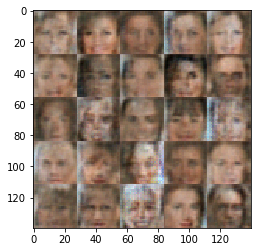

Step: 551
Step: 552
Step: 553
Step: 554
Step: 555
Step: 556
Step: 557
Step: 558
Step: 559
Step: 560
Epoch 560/1... Discriminator Loss: 1.5791... Generator Loss: 0.3524
Step: 561
Step: 562
Step: 563
Step: 564
Step: 565
Step: 566
Step: 567
Step: 568
Step: 569
Step: 570
Epoch 570/1... Discriminator Loss: 1.0505... Generator Loss: 0.7294
Step: 571
Step: 572
Step: 573
Step: 574
Step: 575
Step: 576
Step: 577
Step: 578
Step: 579
Step: 580
Epoch 580/1... Discriminator Loss: 1.7681... Generator Loss: 0.3158
Step: 581
Step: 582
Step: 583
Step: 584
Step: 585
Step: 586
Step: 587
Step: 588
Step: 589
Step: 590
Epoch 590/1... Discriminator Loss: 1.0774... Generator Loss: 0.7498
Step: 591
Step: 592
Step: 593
Step: 594
Step: 595
Step: 596
Step: 597
Step: 598
Step: 599
Step: 600
Epoch 600/1... Discriminator Loss: 1.2425... Generator Loss: 1.1258


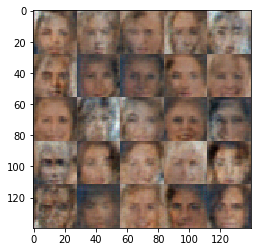

Step: 601
Step: 602
Step: 603
Step: 604
Step: 605
Step: 606
Step: 607
Step: 608
Step: 609
Step: 610
Epoch 610/1... Discriminator Loss: 0.8171... Generator Loss: 2.1011
Step: 611
Step: 612
Step: 613
Step: 614
Step: 615
Step: 616
Step: 617
Step: 618
Step: 619
Step: 620
Epoch 620/1... Discriminator Loss: 1.0406... Generator Loss: 0.6114
Step: 621
Step: 622
Step: 623
Step: 624
Step: 625
Step: 626
Step: 627
Step: 628
Step: 629
Step: 630
Epoch 630/1... Discriminator Loss: 1.4450... Generator Loss: 0.3890
Step: 631
Step: 632
Step: 633
Step: 634
Step: 635
Step: 636
Step: 637
Step: 638
Step: 639
Step: 640
Epoch 640/1... Discriminator Loss: 1.5159... Generator Loss: 0.3820
Step: 641
Step: 642
Step: 643
Step: 644
Step: 645
Step: 646
Step: 647
Step: 648
Step: 649
Step: 650
Epoch 650/1... Discriminator Loss: 2.0876... Generator Loss: 0.2285


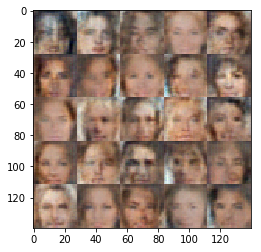

Step: 651
Step: 652
Step: 653
Step: 654
Step: 655
Step: 656
Step: 657
Step: 658
Step: 659
Step: 660
Epoch 660/1... Discriminator Loss: 0.9434... Generator Loss: 0.8157
Step: 661
Step: 662
Step: 663
Step: 664
Step: 665
Step: 666
Step: 667
Step: 668
Step: 669
Step: 670
Epoch 670/1... Discriminator Loss: 0.8055... Generator Loss: 1.1468
Step: 671
Step: 672
Step: 673
Step: 674
Step: 675
Step: 676
Step: 677
Step: 678
Step: 679
Step: 680
Epoch 680/1... Discriminator Loss: 2.3367... Generator Loss: 0.1761
Step: 681
Step: 682
Step: 683
Step: 684
Step: 685
Step: 686
Step: 687
Step: 688
Step: 689
Step: 690
Epoch 690/1... Discriminator Loss: 0.6389... Generator Loss: 1.2791
Step: 691
Step: 692
Step: 693
Step: 694
Step: 695
Step: 696
Step: 697
Step: 698
Step: 699
Step: 700
Epoch 700/1... Discriminator Loss: 1.0629... Generator Loss: 1.4290


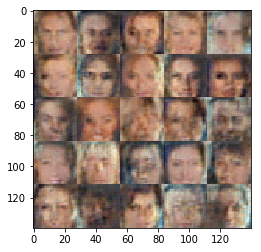

Step: 701
Step: 702
Step: 703
Step: 704
Step: 705
Step: 706
Step: 707
Step: 708
Step: 709
Step: 710
Epoch 710/1... Discriminator Loss: 0.8626... Generator Loss: 1.0825
Step: 711
Step: 712
Step: 713
Step: 714
Step: 715
Step: 716
Step: 717
Step: 718
Step: 719
Step: 720
Epoch 720/1... Discriminator Loss: 1.1419... Generator Loss: 0.6148
Step: 721
Step: 722
Step: 723
Step: 724
Step: 725
Step: 726
Step: 727
Step: 728
Step: 729
Step: 730
Epoch 730/1... Discriminator Loss: 1.0480... Generator Loss: 1.6690
Step: 731
Step: 732
Step: 733
Step: 734
Step: 735
Step: 736
Step: 737
Step: 738
Step: 739
Step: 740
Epoch 740/1... Discriminator Loss: 0.9731... Generator Loss: 0.7821
Step: 741
Step: 742
Step: 743
Step: 744
Step: 745
Step: 746
Step: 747
Step: 748
Step: 749
Step: 750
Epoch 750/1... Discriminator Loss: 0.6331... Generator Loss: 3.0423


Step: 751
Step: 752
Step: 753
Step: 754
Step: 755
Step: 756
Step: 757
Step: 758
Step: 759
Step: 760
Epoch 760/1... Discriminator Loss: 0.6015... Generator Loss: 1.0936
Step: 761
Step: 762
Step: 763
Step: 764
Step: 765
Step: 766
Step: 767
Step: 768
Step: 769
Step: 770
Epoch 770/1... Discriminator Loss: 1.4135... Generator Loss: 1.2979
Step: 771
Step: 772
Step: 773
Step: 774
Step: 775
Step: 776
Step: 777
Step: 778
Step: 779
Step: 780
Epoch 780/1... Discriminator Loss: 1.0640... Generator Loss: 0.6097
Step: 781
Step: 782
Step: 783
Step: 784
Step: 785
Step: 786
Step: 787
Step: 788
Step: 789
Step: 790
Epoch 790/1... Discriminator Loss: 0.9933... Generator Loss: 0.7148
Step: 791
Step: 792
Step: 793
Step: 794
Step: 795
Step: 796
Step: 797
Step: 798
Step: 799
Step: 800
Epoch 800/1... Discriminator Loss: 0.8645... Generator Loss: 1.0506


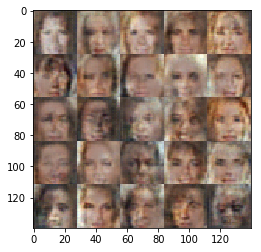

Step: 801
Step: 802
Step: 803
Step: 804
Step: 805
Step: 806
Step: 807
Step: 808
Step: 809
Step: 810
Epoch 810/1... Discriminator Loss: 0.6790... Generator Loss: 1.5890
Step: 811
Step: 812
Step: 813
Step: 814
Step: 815
Step: 816
Step: 817
Step: 818
Step: 819
Step: 820
Epoch 820/1... Discriminator Loss: 0.6973... Generator Loss: 1.2160
Step: 821
Step: 822
Step: 823
Step: 824
Step: 825
Step: 826
Step: 827
Step: 828
Step: 829
Step: 830
Epoch 830/1... Discriminator Loss: 4.0326... Generator Loss: 0.5423
Step: 831
Step: 832
Step: 833
Step: 834
Step: 835
Step: 836
Step: 837
Step: 838
Step: 839
Step: 840
Epoch 840/1... Discriminator Loss: 0.7533... Generator Loss: 1.2149
Step: 841
Step: 842
Step: 843
Step: 844
Step: 845
Step: 846
Step: 847
Step: 848
Step: 849
Step: 850
Epoch 850/1... Discriminator Loss: 0.9746... Generator Loss: 0.7559


Step: 851
Step: 852
Step: 853
Step: 854
Step: 855
Step: 856
Step: 857
Step: 858
Step: 859
Step: 860
Epoch 860/1... Discriminator Loss: 1.2673... Generator Loss: 0.6028
Step: 861
Step: 862
Step: 863
Step: 864
Step: 865
Step: 866
Step: 867
Step: 868
Step: 869
Step: 870
Epoch 870/1... Discriminator Loss: 0.7895... Generator Loss: 1.6290
Step: 871
Step: 872
Step: 873
Step: 874
Step: 875
Step: 876
Step: 877
Step: 878
Step: 879
Step: 880
Epoch 880/1... Discriminator Loss: 0.5598... Generator Loss: 1.6979
Step: 881
Step: 882
Step: 883
Step: 884
Step: 885
Step: 886
Step: 887
Step: 888
Step: 889
Step: 890
Epoch 890/1... Discriminator Loss: 1.2248... Generator Loss: 0.5979
Step: 891
Step: 892
Step: 893
Step: 894
Step: 895
Step: 896
Step: 897
Step: 898
Step: 899
Step: 900
Epoch 900/1... Discriminator Loss: 1.2326... Generator Loss: 0.7966


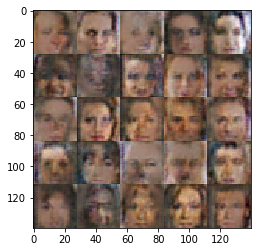

Step: 901
Step: 902
Step: 903
Step: 904
Step: 905
Step: 906
Step: 907
Step: 908
Step: 909
Step: 910
Epoch 910/1... Discriminator Loss: 1.1517... Generator Loss: 0.6190
Step: 911
Step: 912
Step: 913
Step: 914
Step: 915
Step: 916
Step: 917
Step: 918
Step: 919
Step: 920
Epoch 920/1... Discriminator Loss: 0.8716... Generator Loss: 1.0021
Step: 921
Step: 922
Step: 923
Step: 924
Step: 925
Step: 926
Step: 927
Step: 928
Step: 929
Step: 930
Epoch 930/1... Discriminator Loss: 0.6326... Generator Loss: 2.0174
Step: 931
Step: 932
Step: 933
Step: 934
Step: 935
Step: 936
Step: 937
Step: 938
Step: 939
Step: 940
Epoch 940/1... Discriminator Loss: 0.9472... Generator Loss: 0.9258
Step: 941
Step: 942
Step: 943
Step: 944
Step: 945
Step: 946
Step: 947
Step: 948
Step: 949
Step: 950
Epoch 950/1... Discriminator Loss: 0.8946... Generator Loss: 0.8512


Step: 951
Step: 952
Step: 953
Step: 954
Step: 955
Step: 956
Step: 957
Step: 958
Step: 959
Step: 960
Epoch 960/1... Discriminator Loss: 1.2798... Generator Loss: 0.4722
Step: 961
Step: 962
Step: 963
Step: 964
Step: 965
Step: 966
Step: 967
Step: 968
Step: 969
Step: 970
Epoch 970/1... Discriminator Loss: 0.9123... Generator Loss: 1.0684
Step: 971
Step: 972
Step: 973
Step: 974
Step: 975
Step: 976
Step: 977
Step: 978
Step: 979
Step: 980
Epoch 980/1... Discriminator Loss: 1.2008... Generator Loss: 0.7724
Step: 981
Step: 982
Step: 983
Step: 984
Step: 985
Step: 986
Step: 987
Step: 988
Step: 989
Step: 990
Epoch 990/1... Discriminator Loss: 1.1202... Generator Loss: 0.6071
Step: 991
Step: 992
Step: 993
Step: 994
Step: 995
Step: 996
Step: 997
Step: 998
Step: 999
Step: 1000
Epoch 1000/1... Discriminator Loss: 1.0519... Generator Loss: 0.8386


Step: 1001
Step: 1002
Step: 1003
Step: 1004
Step: 1005
Step: 1006
Step: 1007
Step: 1008
Step: 1009
Step: 1010
Epoch 1010/1... Discriminator Loss: 1.2479... Generator Loss: 0.5527
Step: 1011
Step: 1012
Step: 1013
Step: 1014
Step: 1015
Step: 1016
Step: 1017
Step: 1018
Step: 1019
Step: 1020
Epoch 1020/1... Discriminator Loss: 0.8711... Generator Loss: 1.1802
Step: 1021
Step: 1022
Step: 1023
Step: 1024
Step: 1025
Step: 1026
Step: 1027
Step: 1028
Step: 1029
Step: 1030
Epoch 1030/1... Discriminator Loss: 0.8947... Generator Loss: 0.9520
Step: 1031
Step: 1032
Step: 1033
Step: 1034
Step: 1035
Step: 1036
Step: 1037
Step: 1038
Step: 1039
Step: 1040
Epoch 1040/1... Discriminator Loss: 1.0905... Generator Loss: 0.8965
Step: 1041
Step: 1042
Step: 1043
Step: 1044
Step: 1045
Step: 1046
Step: 1047
Step: 1048
Step: 1049
Step: 1050
Epoch 1050/1... Discriminator Loss: 0.8846... Generator Loss: 0.9087


Step: 1051
Step: 1052
Step: 1053
Step: 1054
Step: 1055
Step: 1056
Step: 1057
Step: 1058
Step: 1059
Step: 1060
Epoch 1060/1... Discriminator Loss: 0.7804... Generator Loss: 1.1502
Step: 1061
Step: 1062
Step: 1063
Step: 1064
Step: 1065
Step: 1066
Step: 1067
Step: 1068
Step: 1069
Step: 1070
Epoch 1070/1... Discriminator Loss: 1.4067... Generator Loss: 0.4208
Step: 1071
Step: 1072
Step: 1073
Step: 1074
Step: 1075
Step: 1076
Step: 1077
Step: 1078
Step: 1079
Step: 1080
Epoch 1080/1... Discriminator Loss: 0.9966... Generator Loss: 0.7965
Step: 1081
Step: 1082
Step: 1083
Step: 1084
Step: 1085
Step: 1086
Step: 1087
Step: 1088
Step: 1089
Step: 1090
Epoch 1090/1... Discriminator Loss: 1.6383... Generator Loss: 0.3529
Step: 1091
Step: 1092
Step: 1093
Step: 1094
Step: 1095
Step: 1096
Step: 1097
Step: 1098
Step: 1099
Step: 1100
Epoch 1100/1... Discriminator Loss: 1.8176... Generator Loss: 0.2574


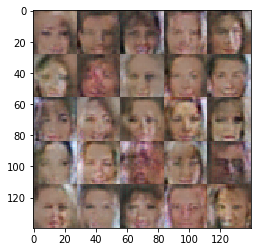

Step: 1101
Step: 1102
Step: 1103
Step: 1104
Step: 1105
Step: 1106
Step: 1107
Step: 1108
Step: 1109
Step: 1110
Epoch 1110/1... Discriminator Loss: 1.2466... Generator Loss: 0.9372
Step: 1111
Step: 1112
Step: 1113
Step: 1114
Step: 1115
Step: 1116
Step: 1117
Step: 1118
Step: 1119
Step: 1120
Epoch 1120/1... Discriminator Loss: 1.0975... Generator Loss: 0.7445
Step: 1121
Step: 1122
Step: 1123
Step: 1124
Step: 1125
Step: 1126
Step: 1127
Step: 1128
Step: 1129
Step: 1130
Epoch 1130/1... Discriminator Loss: 0.8229... Generator Loss: 1.0139
Step: 1131
Step: 1132
Step: 1133
Step: 1134
Step: 1135
Step: 1136
Step: 1137
Step: 1138
Step: 1139
Step: 1140
Epoch 1140/1... Discriminator Loss: 0.8632... Generator Loss: 1.0342
Step: 1141
Step: 1142
Step: 1143
Step: 1144
Step: 1145
Step: 1146
Step: 1147
Step: 1148
Step: 1149
Step: 1150
Epoch 1150/1... Discriminator Loss: 1.0710... Generator Loss: 0.6737


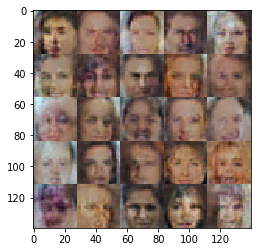

Step: 1151
Step: 1152
Step: 1153
Step: 1154
Step: 1155
Step: 1156
Step: 1157
Step: 1158
Step: 1159
Step: 1160
Epoch 1160/1... Discriminator Loss: 1.3911... Generator Loss: 0.4348
Step: 1161
Step: 1162
Step: 1163
Step: 1164
Step: 1165
Step: 1166
Step: 1167
Step: 1168
Step: 1169
Step: 1170
Epoch 1170/1... Discriminator Loss: 0.8980... Generator Loss: 0.8040
Step: 1171
Step: 1172
Step: 1173
Step: 1174
Step: 1175
Step: 1176
Step: 1177
Step: 1178
Step: 1179
Step: 1180
Epoch 1180/1... Discriminator Loss: 0.9171... Generator Loss: 0.8065
Step: 1181
Step: 1182
Step: 1183
Step: 1184
Step: 1185
Step: 1186
Step: 1187
Step: 1188
Step: 1189
Step: 1190
Epoch 1190/1... Discriminator Loss: 1.3914... Generator Loss: 0.4044
Step: 1191
Step: 1192
Step: 1193
Step: 1194
Step: 1195
Step: 1196
Step: 1197
Step: 1198
Step: 1199
Step: 1200
Epoch 1200/1... Discriminator Loss: 1.3348... Generator Loss: 0.4303


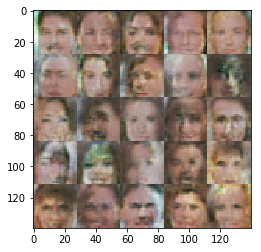

Step: 1201
Step: 1202
Step: 1203
Step: 1204
Step: 1205
Step: 1206
Step: 1207
Step: 1208
Step: 1209
Step: 1210
Epoch 1210/1... Discriminator Loss: 1.0014... Generator Loss: 0.9463
Step: 1211
Step: 1212
Step: 1213
Step: 1214
Step: 1215
Step: 1216
Step: 1217
Step: 1218
Step: 1219
Step: 1220
Epoch 1220/1... Discriminator Loss: 1.1825... Generator Loss: 0.6399
Step: 1221
Step: 1222
Step: 1223
Step: 1224
Step: 1225
Step: 1226
Step: 1227
Step: 1228
Step: 1229
Step: 1230
Epoch 1230/1... Discriminator Loss: 1.1145... Generator Loss: 0.6048
Step: 1231
Step: 1232
Step: 1233
Step: 1234
Step: 1235
Step: 1236
Step: 1237
Step: 1238
Step: 1239
Step: 1240
Epoch 1240/1... Discriminator Loss: 1.0173... Generator Loss: 0.7426
Step: 1241
Step: 1242
Step: 1243
Step: 1244
Step: 1245
Step: 1246
Step: 1247
Step: 1248
Step: 1249
Step: 1250
Epoch 1250/1... Discriminator Loss: 1.1669... Generator Loss: 0.5989


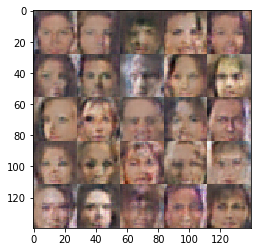

Step: 1251
Step: 1252
Step: 1253
Step: 1254
Step: 1255
Step: 1256
Step: 1257
Step: 1258
Step: 1259
Step: 1260
Epoch 1260/1... Discriminator Loss: 0.9864... Generator Loss: 0.7743
Step: 1261
Step: 1262
Step: 1263
Step: 1264
Step: 1265
Step: 1266
Step: 1267
Step: 1268
Step: 1269
Step: 1270
Epoch 1270/1... Discriminator Loss: 1.5866... Generator Loss: 0.3000
Step: 1271
Step: 1272
Step: 1273
Step: 1274
Step: 1275
Step: 1276
Step: 1277
Step: 1278
Step: 1279
Step: 1280
Epoch 1280/1... Discriminator Loss: 1.0204... Generator Loss: 0.6920
Step: 1281
Step: 1282
Step: 1283
Step: 1284
Step: 1285
Step: 1286
Step: 1287
Step: 1288
Step: 1289
Step: 1290
Epoch 1290/1... Discriminator Loss: 1.3166... Generator Loss: 0.4858
Step: 1291
Step: 1292
Step: 1293
Step: 1294
Step: 1295
Step: 1296
Step: 1297
Step: 1298
Step: 1299
Step: 1300
Epoch 1300/1... Discriminator Loss: 1.0786... Generator Loss: 0.8100


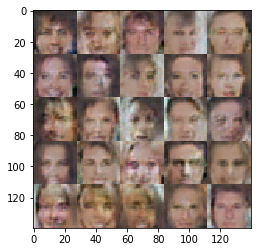

Step: 1301
Step: 1302
Step: 1303
Step: 1304
Step: 1305
Step: 1306
Step: 1307
Step: 1308
Step: 1309
Step: 1310
Epoch 1310/1... Discriminator Loss: 1.0988... Generator Loss: 0.6907
Step: 1311
Step: 1312
Step: 1313
Step: 1314
Step: 1315
Step: 1316
Step: 1317
Step: 1318
Step: 1319
Step: 1320
Epoch 1320/1... Discriminator Loss: 0.9012... Generator Loss: 1.0894
Step: 1321
Step: 1322
Step: 1323
Step: 1324
Step: 1325
Step: 1326
Step: 1327
Step: 1328
Step: 1329
Step: 1330
Epoch 1330/1... Discriminator Loss: 1.0646... Generator Loss: 0.9019
Step: 1331
Step: 1332
Step: 1333
Step: 1334
Step: 1335
Step: 1336
Step: 1337
Step: 1338
Step: 1339
Step: 1340
Epoch 1340/1... Discriminator Loss: 1.1272... Generator Loss: 0.6356
Step: 1341
Step: 1342
Step: 1343
Step: 1344
Step: 1345
Step: 1346
Step: 1347
Step: 1348
Step: 1349
Step: 1350
Epoch 1350/1... Discriminator Loss: 1.0756... Generator Loss: 0.5575


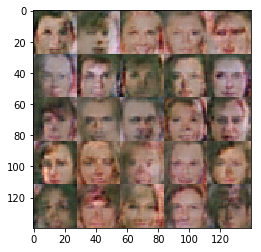

Step: 1351
Step: 1352
Step: 1353
Step: 1354
Step: 1355
Step: 1356
Step: 1357
Step: 1358
Step: 1359
Step: 1360
Epoch 1360/1... Discriminator Loss: 0.8957... Generator Loss: 1.0365
Step: 1361
Step: 1362
Step: 1363
Step: 1364
Step: 1365
Step: 1366
Step: 1367
Step: 1368
Step: 1369
Step: 1370
Epoch 1370/1... Discriminator Loss: 1.5486... Generator Loss: 0.3446
Step: 1371
Step: 1372
Step: 1373
Step: 1374
Step: 1375
Step: 1376
Step: 1377
Step: 1378
Step: 1379
Step: 1380
Epoch 1380/1... Discriminator Loss: 1.0190... Generator Loss: 0.7520
Step: 1381
Step: 1382
Step: 1383
Step: 1384
Step: 1385
Step: 1386
Step: 1387
Step: 1388
Step: 1389
Step: 1390
Epoch 1390/1... Discriminator Loss: 1.3820... Generator Loss: 0.5690
Step: 1391
Step: 1392
Step: 1393
Step: 1394
Step: 1395
Step: 1396
Step: 1397
Step: 1398
Step: 1399
Step: 1400
Epoch 1400/1... Discriminator Loss: 1.1172... Generator Loss: 1.1094


Step: 1401
Step: 1402
Step: 1403
Step: 1404
Step: 1405
Step: 1406
Step: 1407
Step: 1408
Step: 1409
Step: 1410
Epoch 1410/1... Discriminator Loss: 1.2779... Generator Loss: 0.5699
Step: 1411
Step: 1412
Step: 1413
Step: 1414
Step: 1415
Step: 1416
Step: 1417
Step: 1418
Step: 1419
Step: 1420
Epoch 1420/1... Discriminator Loss: 1.0497... Generator Loss: 1.1011
Step: 1421
Step: 1422
Step: 1423
Step: 1424
Step: 1425
Step: 1426
Step: 1427
Step: 1428
Step: 1429
Step: 1430
Epoch 1430/1... Discriminator Loss: 0.9173... Generator Loss: 0.9662
Step: 1431
Step: 1432
Step: 1433
Step: 1434
Step: 1435
Step: 1436
Step: 1437
Step: 1438
Step: 1439
Step: 1440
Epoch 1440/1... Discriminator Loss: 0.8080... Generator Loss: 0.9910
Step: 1441
Step: 1442
Step: 1443
Step: 1444
Step: 1445
Step: 1446
Step: 1447
Step: 1448
Step: 1449
Step: 1450
Epoch 1450/1... Discriminator Loss: 1.3576... Generator Loss: 0.4446


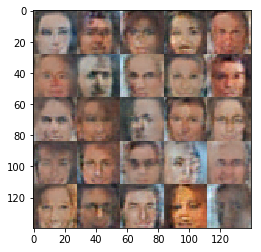

Step: 1451
Step: 1452
Step: 1453
Step: 1454
Step: 1455
Step: 1456
Step: 1457
Step: 1458
Step: 1459
Step: 1460
Epoch 1460/1... Discriminator Loss: 0.8301... Generator Loss: 1.1029
Step: 1461
Step: 1462
Step: 1463
Step: 1464
Step: 1465
Step: 1466
Step: 1467
Step: 1468
Step: 1469
Step: 1470
Epoch 1470/1... Discriminator Loss: 1.0754... Generator Loss: 0.6463
Step: 1471
Step: 1472
Step: 1473
Step: 1474
Step: 1475
Step: 1476
Step: 1477
Step: 1478
Step: 1479
Step: 1480
Epoch 1480/1... Discriminator Loss: 1.5883... Generator Loss: 0.3501
Step: 1481
Step: 1482
Step: 1483
Step: 1484
Step: 1485
Step: 1486
Step: 1487
Step: 1488
Step: 1489
Step: 1490
Epoch 1490/1... Discriminator Loss: 0.9849... Generator Loss: 0.9295
Step: 1491
Step: 1492
Step: 1493
Step: 1494
Step: 1495
Step: 1496
Step: 1497
Step: 1498
Step: 1499
Step: 1500
Epoch 1500/1... Discriminator Loss: 1.3266... Generator Loss: 0.5018


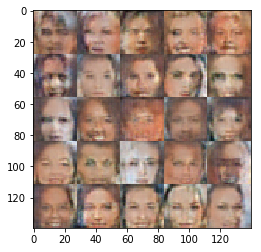

Step: 1501
Step: 1502
Step: 1503
Step: 1504
Step: 1505
Step: 1506
Step: 1507
Step: 1508
Step: 1509
Step: 1510
Epoch 1510/1... Discriminator Loss: 1.0180... Generator Loss: 1.1601
Step: 1511
Step: 1512
Step: 1513
Step: 1514
Step: 1515
Step: 1516
Step: 1517
Step: 1518
Step: 1519
Step: 1520
Epoch 1520/1... Discriminator Loss: 1.0961... Generator Loss: 0.6345
Step: 1521
Step: 1522
Step: 1523
Step: 1524
Step: 1525
Step: 1526
Step: 1527
Step: 1528
Step: 1529
Step: 1530
Epoch 1530/1... Discriminator Loss: 0.9779... Generator Loss: 0.7909
Step: 1531
Step: 1532
Step: 1533
Step: 1534
Step: 1535
Step: 1536
Step: 1537
Step: 1538
Step: 1539
Step: 1540
Epoch 1540/1... Discriminator Loss: 1.1307... Generator Loss: 0.6612
Step: 1541
Step: 1542
Step: 1543
Step: 1544
Step: 1545
Step: 1546
Step: 1547
Step: 1548
Step: 1549
Step: 1550
Epoch 1550/1... Discriminator Loss: 0.9772... Generator Loss: 1.2199


Step: 1551
Step: 1552
Step: 1553
Step: 1554
Step: 1555
Step: 1556
Step: 1557
Step: 1558
Step: 1559
Step: 1560
Epoch 1560/1... Discriminator Loss: 0.9393... Generator Loss: 1.3526
Step: 1561
Step: 1562
Step: 1563
Step: 1564
Step: 1565
Step: 1566
Step: 1567
Step: 1568
Step: 1569
Step: 1570
Epoch 1570/1... Discriminator Loss: 1.2249... Generator Loss: 0.5250
Step: 1571
Step: 1572
Step: 1573
Step: 1574
Step: 1575
Step: 1576
Step: 1577
Step: 1578
Step: 1579
Step: 1580
Epoch 1580/1... Discriminator Loss: 1.0837... Generator Loss: 0.9235
Step: 1581
Step: 1582
Step: 1583
Step: 1584
Step: 1585
Step: 1586
Step: 1587
Step: 1588
Step: 1589
Step: 1590
Epoch 1590/1... Discriminator Loss: 0.8718... Generator Loss: 0.8018
Step: 1591
Step: 1592
Step: 1593
Step: 1594
Step: 1595
Step: 1596
Step: 1597
Step: 1598
Step: 1599
Step: 1600
Epoch 1600/1... Discriminator Loss: 1.2339... Generator Loss: 0.6719


Step: 1601
Step: 1602
Step: 1603
Step: 1604
Step: 1605
Step: 1606
Step: 1607
Step: 1608
Step: 1609
Step: 1610
Epoch 1610/1... Discriminator Loss: 0.8960... Generator Loss: 1.3450
Step: 1611
Step: 1612
Step: 1613
Step: 1614
Step: 1615
Step: 1616
Step: 1617
Step: 1618
Step: 1619
Step: 1620
Epoch 1620/1... Discriminator Loss: 0.9021... Generator Loss: 0.8236
Step: 1621
Step: 1622
Step: 1623
Step: 1624
Step: 1625
Step: 1626
Step: 1627
Step: 1628
Step: 1629
Step: 1630
Epoch 1630/1... Discriminator Loss: 0.8499... Generator Loss: 0.9561
Step: 1631
Step: 1632
Step: 1633
Step: 1634
Step: 1635
Step: 1636
Step: 1637
Step: 1638
Step: 1639
Step: 1640
Epoch 1640/1... Discriminator Loss: 0.7033... Generator Loss: 1.4163
Step: 1641
Step: 1642
Step: 1643
Step: 1644
Step: 1645
Step: 1646
Step: 1647
Step: 1648
Step: 1649
Step: 1650
Epoch 1650/1... Discriminator Loss: 1.0799... Generator Loss: 0.7294


Step: 1651
Step: 1652
Step: 1653
Step: 1654
Step: 1655
Step: 1656
Step: 1657
Step: 1658
Step: 1659
Step: 1660
Epoch 1660/1... Discriminator Loss: 1.5365... Generator Loss: 2.1128
Step: 1661
Step: 1662
Step: 1663
Step: 1664
Step: 1665
Step: 1666
Step: 1667
Step: 1668
Step: 1669
Step: 1670
Epoch 1670/1... Discriminator Loss: 0.9086... Generator Loss: 1.0069
Step: 1671
Step: 1672
Step: 1673
Step: 1674
Step: 1675
Step: 1676
Step: 1677
Step: 1678
Step: 1679
Step: 1680
Epoch 1680/1... Discriminator Loss: 0.8600... Generator Loss: 1.2837
Step: 1681
Step: 1682
Step: 1683
Step: 1684
Step: 1685
Step: 1686
Step: 1687
Step: 1688
Step: 1689
Step: 1690
Epoch 1690/1... Discriminator Loss: 1.5382... Generator Loss: 0.3563
Step: 1691
Step: 1692
Step: 1693
Step: 1694
Step: 1695
Step: 1696
Step: 1697
Step: 1698
Step: 1699
Step: 1700
Epoch 1700/1... Discriminator Loss: 1.9754... Generator Loss: 2.7997


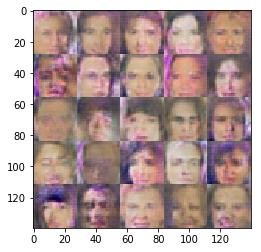

Step: 1701
Step: 1702
Step: 1703
Step: 1704
Step: 1705
Step: 1706
Step: 1707
Step: 1708
Step: 1709
Step: 1710
Epoch 1710/1... Discriminator Loss: 1.0165... Generator Loss: 0.7818
Step: 1711
Step: 1712
Step: 1713
Step: 1714
Step: 1715
Step: 1716
Step: 1717
Step: 1718
Step: 1719
Step: 1720
Epoch 1720/1... Discriminator Loss: 1.4078... Generator Loss: 0.4266
Step: 1721
Step: 1722
Step: 1723
Step: 1724
Step: 1725
Step: 1726
Step: 1727
Step: 1728
Step: 1729
Step: 1730
Epoch 1730/1... Discriminator Loss: 1.0055... Generator Loss: 0.8373
Step: 1731
Step: 1732
Step: 1733
Step: 1734
Step: 1735
Step: 1736
Step: 1737
Step: 1738
Step: 1739
Step: 1740
Epoch 1740/1... Discriminator Loss: 0.9741... Generator Loss: 0.8054
Step: 1741
Step: 1742
Step: 1743
Step: 1744
Step: 1745
Step: 1746
Step: 1747
Step: 1748
Step: 1749
Step: 1750
Epoch 1750/1... Discriminator Loss: 0.6442... Generator Loss: 1.5636


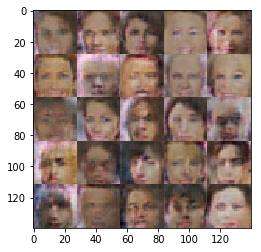

Step: 1751
Step: 1752
Step: 1753
Step: 1754
Step: 1755
Step: 1756
Step: 1757
Step: 1758
Step: 1759
Step: 1760
Epoch 1760/1... Discriminator Loss: 1.1958... Generator Loss: 0.5173
Step: 1761
Step: 1762
Step: 1763
Step: 1764
Step: 1765
Step: 1766
Step: 1767
Step: 1768
Step: 1769
Step: 1770
Epoch 1770/1... Discriminator Loss: 0.5074... Generator Loss: 1.2955
Step: 1771
Step: 1772
Step: 1773
Step: 1774
Step: 1775
Step: 1776
Step: 1777
Step: 1778
Step: 1779
Step: 1780
Epoch 1780/1... Discriminator Loss: 1.0980... Generator Loss: 1.3624
Step: 1781
Step: 1782
Step: 1783
Step: 1784
Step: 1785
Step: 1786
Step: 1787
Step: 1788
Step: 1789
Step: 1790
Epoch 1790/1... Discriminator Loss: 1.0072... Generator Loss: 0.6275
Step: 1791
Step: 1792
Step: 1793
Step: 1794
Step: 1795
Step: 1796
Step: 1797
Step: 1798
Step: 1799
Step: 1800
Epoch 1800/1... Discriminator Loss: 0.6637... Generator Loss: 1.0309


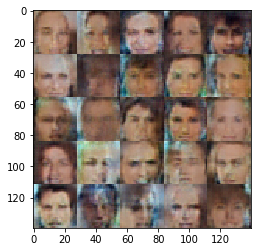

Step: 1801
Step: 1802
Step: 1803
Step: 1804
Step: 1805
Step: 1806
Step: 1807
Step: 1808
Step: 1809
Step: 1810
Epoch 1810/1... Discriminator Loss: 1.3520... Generator Loss: 0.4120
Step: 1811
Step: 1812
Step: 1813
Step: 1814
Step: 1815
Step: 1816
Step: 1817
Step: 1818
Step: 1819
Step: 1820
Epoch 1820/1... Discriminator Loss: 0.5661... Generator Loss: 1.3455
Step: 1821
Step: 1822
Step: 1823
Step: 1824
Step: 1825
Step: 1826
Step: 1827
Step: 1828
Step: 1829
Step: 1830
Epoch 1830/1... Discriminator Loss: 1.6632... Generator Loss: 0.3084
Step: 1831
Step: 1832
Step: 1833
Step: 1834
Step: 1835
Step: 1836
Step: 1837
Step: 1838
Step: 1839
Step: 1840
Epoch 1840/1... Discriminator Loss: 1.8025... Generator Loss: 0.2479
Step: 1841
Step: 1842
Step: 1843
Step: 1844
Step: 1845
Step: 1846
Step: 1847
Step: 1848
Step: 1849
Step: 1850
Epoch 1850/1... Discriminator Loss: 1.3048... Generator Loss: 0.5429


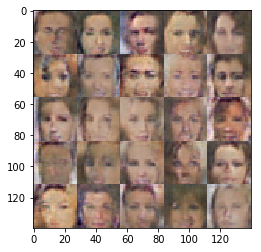

Step: 1851
Step: 1852
Step: 1853
Step: 1854
Step: 1855
Step: 1856
Step: 1857
Step: 1858
Step: 1859
Step: 1860
Epoch 1860/1... Discriminator Loss: 0.7749... Generator Loss: 1.3543
Step: 1861
Step: 1862
Step: 1863
Step: 1864
Step: 1865
Step: 1866
Step: 1867
Step: 1868
Step: 1869
Step: 1870
Epoch 1870/1... Discriminator Loss: 1.1883... Generator Loss: 0.4691
Step: 1871
Step: 1872
Step: 1873
Step: 1874
Step: 1875
Step: 1876
Step: 1877
Step: 1878
Step: 1879
Step: 1880
Epoch 1880/1... Discriminator Loss: 1.3183... Generator Loss: 0.4670
Step: 1881
Step: 1882
Step: 1883
Step: 1884
Step: 1885
Step: 1886
Step: 1887
Step: 1888
Step: 1889
Step: 1890
Epoch 1890/1... Discriminator Loss: 1.1467... Generator Loss: 0.5127
Step: 1891
Step: 1892
Step: 1893
Step: 1894
Step: 1895
Step: 1896
Step: 1897
Step: 1898
Step: 1899
Step: 1900
Epoch 1900/1... Discriminator Loss: 0.6468... Generator Loss: 1.2980


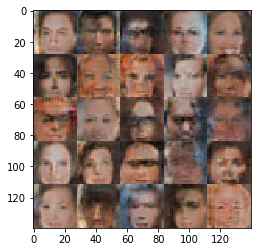

Step: 1901
Step: 1902
Step: 1903
Step: 1904
Step: 1905
Step: 1906
Step: 1907
Step: 1908
Step: 1909
Step: 1910
Epoch 1910/1... Discriminator Loss: 0.8056... Generator Loss: 1.0060
Step: 1911
Step: 1912
Step: 1913
Step: 1914
Step: 1915
Step: 1916
Step: 1917
Step: 1918
Step: 1919
Step: 1920
Epoch 1920/1... Discriminator Loss: 0.9760... Generator Loss: 0.7605
Step: 1921
Step: 1922
Step: 1923
Step: 1924
Step: 1925
Step: 1926
Step: 1927
Step: 1928
Step: 1929
Step: 1930
Epoch 1930/1... Discriminator Loss: 1.3735... Generator Loss: 0.5377
Step: 1931
Step: 1932
Step: 1933
Step: 1934
Step: 1935
Step: 1936
Step: 1937
Step: 1938
Step: 1939
Step: 1940
Epoch 1940/1... Discriminator Loss: 1.3263... Generator Loss: 0.4816
Step: 1941
Step: 1942
Step: 1943
Step: 1944
Step: 1945
Step: 1946
Step: 1947
Step: 1948
Step: 1949
Step: 1950
Epoch 1950/1... Discriminator Loss: 0.9147... Generator Loss: 1.3347


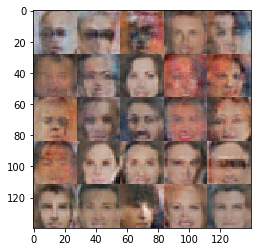

Step: 1951
Step: 1952
Step: 1953
Step: 1954
Step: 1955
Step: 1956
Step: 1957
Step: 1958
Step: 1959
Step: 1960
Epoch 1960/1... Discriminator Loss: 1.0581... Generator Loss: 0.6296
Step: 1961
Step: 1962
Step: 1963
Step: 1964
Step: 1965
Step: 1966
Step: 1967
Step: 1968
Step: 1969
Step: 1970
Epoch 1970/1... Discriminator Loss: 1.2289... Generator Loss: 0.4902
Step: 1971
Step: 1972
Step: 1973
Step: 1974
Step: 1975
Step: 1976
Step: 1977
Step: 1978
Step: 1979
Step: 1980
Epoch 1980/1... Discriminator Loss: 1.2498... Generator Loss: 0.7110
Step: 1981
Step: 1982
Step: 1983
Step: 1984
Step: 1985
Step: 1986
Step: 1987
Step: 1988
Step: 1989
Step: 1990
Epoch 1990/1... Discriminator Loss: 1.0095... Generator Loss: 0.7505
Step: 1991
Step: 1992
Step: 1993
Step: 1994
Step: 1995
Step: 1996
Step: 1997
Step: 1998
Step: 1999
Step: 2000
Epoch 2000/1... Discriminator Loss: 0.6829... Generator Loss: 1.3516


Step: 2001
Step: 2002
Step: 2003
Step: 2004
Step: 2005
Step: 2006
Step: 2007
Step: 2008
Step: 2009
Step: 2010
Epoch 2010/1... Discriminator Loss: 1.2385... Generator Loss: 0.4827
Step: 2011
Step: 2012
Step: 2013
Step: 2014
Step: 2015
Step: 2016
Step: 2017
Step: 2018
Step: 2019
Step: 2020
Epoch 2020/1... Discriminator Loss: 1.0223... Generator Loss: 0.6401
Step: 2021
Step: 2022
Step: 2023
Step: 2024
Step: 2025
Step: 2026
Step: 2027
Step: 2028
Step: 2029
Step: 2030
Epoch 2030/1... Discriminator Loss: 1.7337... Generator Loss: 0.2440
Step: 2031
Step: 2032
Step: 2033
Step: 2034
Step: 2035
Step: 2036
Step: 2037
Step: 2038
Step: 2039
Step: 2040
Epoch 2040/1... Discriminator Loss: 0.6164... Generator Loss: 1.2532
Step: 2041
Step: 2042
Step: 2043
Step: 2044
Step: 2045
Step: 2046
Step: 2047
Step: 2048
Step: 2049
Step: 2050
Epoch 2050/1... Discriminator Loss: 0.7592... Generator Loss: 1.3740


Step: 2051
Step: 2052
Step: 2053
Step: 2054
Step: 2055
Step: 2056
Step: 2057
Step: 2058
Step: 2059
Step: 2060
Epoch 2060/1... Discriminator Loss: 0.8272... Generator Loss: 1.0359
Step: 2061
Step: 2062
Step: 2063
Step: 2064
Step: 2065
Step: 2066
Step: 2067
Step: 2068
Step: 2069
Step: 2070
Epoch 2070/1... Discriminator Loss: 1.6565... Generator Loss: 0.3451
Step: 2071
Step: 2072
Step: 2073
Step: 2074
Step: 2075
Step: 2076
Step: 2077
Step: 2078
Step: 2079
Step: 2080
Epoch 2080/1... Discriminator Loss: 0.9199... Generator Loss: 0.9251
Step: 2081
Step: 2082
Step: 2083
Step: 2084
Step: 2085
Step: 2086
Step: 2087
Step: 2088
Step: 2089
Step: 2090
Epoch 2090/1... Discriminator Loss: 0.8908... Generator Loss: 0.7166
Step: 2091
Step: 2092
Step: 2093
Step: 2094
Step: 2095
Step: 2096
Step: 2097
Step: 2098
Step: 2099
Step: 2100
Epoch 2100/1... Discriminator Loss: 1.3798... Generator Loss: 0.6985


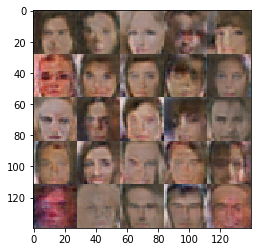

Step: 2101
Step: 2102
Step: 2103
Step: 2104
Step: 2105
Step: 2106
Step: 2107
Step: 2108
Step: 2109
Step: 2110
Epoch 2110/1... Discriminator Loss: 1.0791... Generator Loss: 0.6524
Step: 2111
Step: 2112
Step: 2113
Step: 2114
Step: 2115
Step: 2116
Step: 2117
Step: 2118
Step: 2119
Step: 2120
Epoch 2120/1... Discriminator Loss: 1.0007... Generator Loss: 0.7520
Step: 2121
Step: 2122
Step: 2123
Step: 2124
Step: 2125
Step: 2126
Step: 2127
Step: 2128
Step: 2129
Step: 2130
Epoch 2130/1... Discriminator Loss: 0.7814... Generator Loss: 1.2280
Step: 2131
Step: 2132
Step: 2133
Step: 2134
Step: 2135
Step: 2136
Step: 2137
Step: 2138
Step: 2139
Step: 2140
Epoch 2140/1... Discriminator Loss: 0.2197... Generator Loss: 2.9018
Step: 2141
Step: 2142
Step: 2143
Step: 2144
Step: 2145
Step: 2146
Step: 2147
Step: 2148
Step: 2149
Step: 2150
Epoch 2150/1... Discriminator Loss: 0.9072... Generator Loss: 0.9108


Step: 2151
Step: 2152
Step: 2153
Step: 2154
Step: 2155
Step: 2156
Step: 2157
Step: 2158
Step: 2159
Step: 2160
Epoch 2160/1... Discriminator Loss: 2.1034... Generator Loss: 0.2167
Step: 2161
Step: 2162
Step: 2163
Step: 2164
Step: 2165
Step: 2166
Step: 2167
Step: 2168
Step: 2169
Step: 2170
Epoch 2170/1... Discriminator Loss: 1.7271... Generator Loss: 0.3815
Step: 2171
Step: 2172
Step: 2173
Step: 2174
Step: 2175
Step: 2176
Step: 2177
Step: 2178
Step: 2179
Step: 2180
Epoch 2180/1... Discriminator Loss: 0.6907... Generator Loss: 1.1011
Step: 2181
Step: 2182
Step: 2183
Step: 2184
Step: 2185
Step: 2186
Step: 2187
Step: 2188
Step: 2189
Step: 2190
Epoch 2190/1... Discriminator Loss: 0.9610... Generator Loss: 0.8752
Step: 2191
Step: 2192
Step: 2193
Step: 2194
Step: 2195
Step: 2196
Step: 2197
Step: 2198
Step: 2199
Step: 2200
Epoch 2200/1... Discriminator Loss: 0.9383... Generator Loss: 0.8245


Step: 2201
Step: 2202
Step: 2203
Step: 2204
Step: 2205
Step: 2206
Step: 2207
Step: 2208
Step: 2209
Step: 2210
Epoch 2210/1... Discriminator Loss: 0.3631... Generator Loss: 2.1306
Step: 2211
Step: 2212
Step: 2213
Step: 2214
Step: 2215
Step: 2216
Step: 2217
Step: 2218
Step: 2219
Step: 2220
Epoch 2220/1... Discriminator Loss: 0.8340... Generator Loss: 0.9831
Step: 2221
Step: 2222
Step: 2223
Step: 2224
Step: 2225
Step: 2226
Step: 2227
Step: 2228
Step: 2229
Step: 2230
Epoch 2230/1... Discriminator Loss: 0.7843... Generator Loss: 1.0638
Step: 2231
Step: 2232
Step: 2233
Step: 2234
Step: 2235
Step: 2236
Step: 2237
Step: 2238
Step: 2239
Step: 2240
Epoch 2240/1... Discriminator Loss: 0.8770... Generator Loss: 1.3101
Step: 2241
Step: 2242
Step: 2243
Step: 2244
Step: 2245
Step: 2246
Step: 2247
Step: 2248
Step: 2249
Step: 2250
Epoch 2250/1... Discriminator Loss: 0.9964... Generator Loss: 0.7112


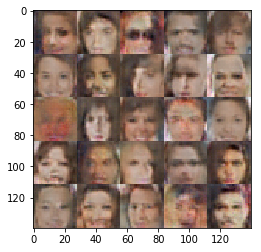

Step: 2251
Step: 2252
Step: 2253
Step: 2254
Step: 2255
Step: 2256
Step: 2257
Step: 2258
Step: 2259
Step: 2260
Epoch 2260/1... Discriminator Loss: 1.6593... Generator Loss: 0.3070
Step: 2261
Step: 2262
Step: 2263
Step: 2264
Step: 2265
Step: 2266
Step: 2267
Step: 2268
Step: 2269
Step: 2270
Epoch 2270/1... Discriminator Loss: 1.3169... Generator Loss: 0.4236
Step: 2271
Step: 2272
Step: 2273
Step: 2274
Step: 2275
Step: 2276
Step: 2277
Step: 2278
Step: 2279
Step: 2280
Epoch 2280/1... Discriminator Loss: 0.9492... Generator Loss: 1.1234
Step: 2281
Step: 2282
Step: 2283
Step: 2284
Step: 2285
Step: 2286
Step: 2287
Step: 2288
Step: 2289
Step: 2290
Epoch 2290/1... Discriminator Loss: 1.1357... Generator Loss: 0.6108
Step: 2291
Step: 2292
Step: 2293
Step: 2294
Step: 2295
Step: 2296
Step: 2297
Step: 2298
Step: 2299
Step: 2300
Epoch 2300/1... Discriminator Loss: 1.1715... Generator Loss: 0.5684


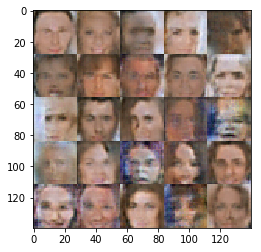

Step: 2301
Step: 2302
Step: 2303
Step: 2304
Step: 2305
Step: 2306
Step: 2307
Step: 2308
Step: 2309
Step: 2310
Epoch 2310/1... Discriminator Loss: 0.8646... Generator Loss: 0.7924
Step: 2311
Step: 2312
Step: 2313
Step: 2314
Step: 2315
Step: 2316
Step: 2317
Step: 2318
Step: 2319
Step: 2320
Epoch 2320/1... Discriminator Loss: 1.0698... Generator Loss: 0.5766
Step: 2321
Step: 2322
Step: 2323
Step: 2324
Step: 2325
Step: 2326
Step: 2327
Step: 2328
Step: 2329
Step: 2330
Epoch 2330/1... Discriminator Loss: 0.9869... Generator Loss: 0.6511
Step: 2331
Step: 2332
Step: 2333
Step: 2334
Step: 2335
Step: 2336
Step: 2337
Step: 2338
Step: 2339
Step: 2340
Epoch 2340/1... Discriminator Loss: 1.5519... Generator Loss: 0.3741
Step: 2341
Step: 2342
Step: 2343
Step: 2344
Step: 2345
Step: 2346
Step: 2347
Step: 2348
Step: 2349
Step: 2350
Epoch 2350/1... Discriminator Loss: 1.1249... Generator Loss: 0.6791


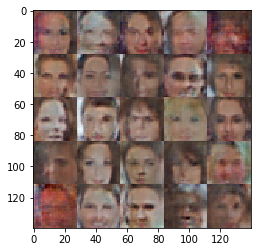

Step: 2351
Step: 2352
Step: 2353
Step: 2354
Step: 2355
Step: 2356
Step: 2357
Step: 2358
Step: 2359
Step: 2360
Epoch 2360/1... Discriminator Loss: 2.4725... Generator Loss: 0.1203
Step: 2361
Step: 2362
Step: 2363
Step: 2364
Step: 2365
Step: 2366
Step: 2367
Step: 2368
Step: 2369
Step: 2370
Epoch 2370/1... Discriminator Loss: 0.9161... Generator Loss: 0.9088
Step: 2371
Step: 2372
Step: 2373
Step: 2374
Step: 2375
Step: 2376
Step: 2377
Step: 2378
Step: 2379
Step: 2380
Epoch 2380/1... Discriminator Loss: 1.0263... Generator Loss: 0.7946
Step: 2381
Step: 2382
Step: 2383
Step: 2384
Step: 2385
Step: 2386
Step: 2387
Step: 2388
Step: 2389
Step: 2390
Epoch 2390/1... Discriminator Loss: 1.4553... Generator Loss: 0.3575
Step: 2391
Step: 2392
Step: 2393
Step: 2394
Step: 2395
Step: 2396
Step: 2397
Step: 2398
Step: 2399
Step: 2400
Epoch 2400/1... Discriminator Loss: 2.1040... Generator Loss: 0.1884


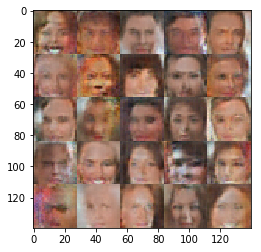

Step: 2401
Step: 2402
Step: 2403
Step: 2404
Step: 2405
Step: 2406
Step: 2407
Step: 2408
Step: 2409
Step: 2410
Epoch 2410/1... Discriminator Loss: 1.4402... Generator Loss: 0.3486
Step: 2411
Step: 2412
Step: 2413
Step: 2414
Step: 2415
Step: 2416
Step: 2417
Step: 2418
Step: 2419
Step: 2420
Epoch 2420/1... Discriminator Loss: 0.8013... Generator Loss: 0.8554
Step: 2421
Step: 2422
Step: 2423
Step: 2424
Step: 2425
Step: 2426
Step: 2427
Step: 2428
Step: 2429
Step: 2430
Epoch 2430/1... Discriminator Loss: 1.6166... Generator Loss: 0.4231
Step: 2431
Step: 2432
Step: 2433
Step: 2434
Step: 2435
Step: 2436
Step: 2437
Step: 2438
Step: 2439
Step: 2440
Epoch 2440/1... Discriminator Loss: 1.4528... Generator Loss: 0.3678
Step: 2441
Step: 2442
Step: 2443
Step: 2444
Step: 2445
Step: 2446
Step: 2447
Step: 2448
Step: 2449
Step: 2450
Epoch 2450/1... Discriminator Loss: 1.1079... Generator Loss: 0.6154


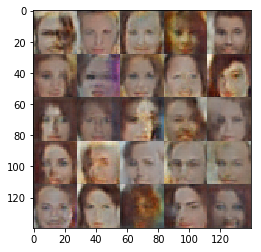

Step: 2451
Step: 2452
Step: 2453
Step: 2454
Step: 2455
Step: 2456
Step: 2457
Step: 2458
Step: 2459
Step: 2460
Epoch 2460/1... Discriminator Loss: 1.1961... Generator Loss: 0.5623
Step: 2461
Step: 2462
Step: 2463
Step: 2464
Step: 2465
Step: 2466
Step: 2467
Step: 2468
Step: 2469
Step: 2470
Epoch 2470/1... Discriminator Loss: 2.2407... Generator Loss: 0.3034
Step: 2471
Step: 2472
Step: 2473
Step: 2474
Step: 2475
Step: 2476
Step: 2477
Step: 2478
Step: 2479
Step: 2480
Epoch 2480/1... Discriminator Loss: 0.8618... Generator Loss: 0.8390
Step: 2481
Step: 2482
Step: 2483
Step: 2484
Step: 2485
Step: 2486
Step: 2487
Step: 2488
Step: 2489
Step: 2490
Epoch 2490/1... Discriminator Loss: 1.8722... Generator Loss: 0.4668
Step: 2491
Step: 2492
Step: 2493
Step: 2494
Step: 2495
Step: 2496
Step: 2497
Step: 2498
Step: 2499
Step: 2500
Epoch 2500/1... Discriminator Loss: 1.0096... Generator Loss: 0.5890


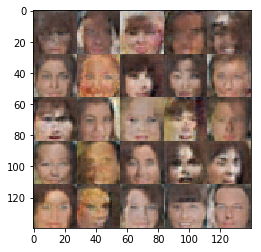

Step: 2501
Step: 2502
Step: 2503
Step: 2504
Step: 2505
Step: 2506
Step: 2507
Step: 2508
Step: 2509
Step: 2510
Epoch 2510/1... Discriminator Loss: 1.2286... Generator Loss: 0.4764
Step: 2511
Step: 2512
Step: 2513
Step: 2514
Step: 2515
Step: 2516
Step: 2517
Step: 2518
Step: 2519
Step: 2520
Epoch 2520/1... Discriminator Loss: 1.2380... Generator Loss: 0.4986
Step: 2521
Step: 2522
Step: 2523
Step: 2524
Step: 2525
Step: 2526
Step: 2527
Step: 2528
Step: 2529
Step: 2530
Epoch 2530/1... Discriminator Loss: 1.4121... Generator Loss: 0.4072
Step: 2531
Step: 2532
Step: 2533
Step: 2534
Step: 2535
Step: 2536
Step: 2537
Step: 2538
Step: 2539
Step: 2540
Epoch 2540/1... Discriminator Loss: 1.2899... Generator Loss: 0.5067
Step: 2541
Step: 2542
Step: 2543
Step: 2544
Step: 2545
Step: 2546
Step: 2547
Step: 2548
Step: 2549
Step: 2550
Epoch 2550/1... Discriminator Loss: 1.2584... Generator Loss: 0.5367


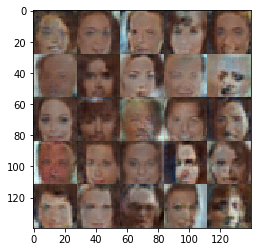

Step: 2551
Step: 2552
Step: 2553
Step: 2554
Step: 2555
Step: 2556
Step: 2557
Step: 2558
Step: 2559
Step: 2560
Epoch 2560/1... Discriminator Loss: 1.6115... Generator Loss: 0.4184
Step: 2561
Step: 2562
Step: 2563
Step: 2564
Step: 2565
Step: 2566
Step: 2567
Step: 2568
Step: 2569
Step: 2570
Epoch 2570/1... Discriminator Loss: 1.3796... Generator Loss: 0.4445
Step: 2571
Step: 2572
Step: 2573
Step: 2574
Step: 2575
Step: 2576
Step: 2577
Step: 2578
Step: 2579
Step: 2580
Epoch 2580/1... Discriminator Loss: 0.8237... Generator Loss: 0.8340
Step: 2581
Step: 2582
Step: 2583
Step: 2584
Step: 2585
Step: 2586
Step: 2587
Step: 2588
Step: 2589
Step: 2590
Epoch 2590/1... Discriminator Loss: 0.9977... Generator Loss: 0.7498
Step: 2591
Step: 2592
Step: 2593
Step: 2594
Step: 2595
Step: 2596
Step: 2597
Step: 2598
Step: 2599
Step: 2600
Epoch 2600/1... Discriminator Loss: 1.5472... Generator Loss: 0.3524


Step: 2601
Step: 2602
Step: 2603
Step: 2604
Step: 2605
Step: 2606
Step: 2607
Step: 2608
Step: 2609
Step: 2610
Epoch 2610/1... Discriminator Loss: 1.0028... Generator Loss: 1.0264
Step: 2611
Step: 2612
Step: 2613
Step: 2614
Step: 2615
Step: 2616
Step: 2617
Step: 2618
Step: 2619
Step: 2620
Epoch 2620/1... Discriminator Loss: 0.9938... Generator Loss: 1.0622
Step: 2621
Step: 2622
Step: 2623
Step: 2624
Step: 2625
Step: 2626
Step: 2627
Step: 2628
Step: 2629
Step: 2630
Epoch 2630/1... Discriminator Loss: 1.2167... Generator Loss: 0.5766
Step: 2631
Step: 2632
Step: 2633
Step: 2634
Step: 2635
Step: 2636
Step: 2637
Step: 2638
Step: 2639
Step: 2640
Epoch 2640/1... Discriminator Loss: 1.1443... Generator Loss: 0.5307
Step: 2641
Step: 2642
Step: 2643
Step: 2644
Step: 2645
Step: 2646
Step: 2647
Step: 2648
Step: 2649
Step: 2650
Epoch 2650/1... Discriminator Loss: 1.1113... Generator Loss: 0.6417


Step: 2651
Step: 2652
Step: 2653
Step: 2654
Step: 2655
Step: 2656
Step: 2657
Step: 2658
Step: 2659
Step: 2660
Epoch 2660/1... Discriminator Loss: 1.2371... Generator Loss: 0.6439
Step: 2661
Step: 2662
Step: 2663
Step: 2664
Step: 2665
Step: 2666
Step: 2667
Step: 2668
Step: 2669
Step: 2670
Epoch 2670/1... Discriminator Loss: 1.2634... Generator Loss: 0.5586
Step: 2671
Step: 2672
Step: 2673
Step: 2674
Step: 2675
Step: 2676
Step: 2677
Step: 2678
Step: 2679
Step: 2680
Epoch 2680/1... Discriminator Loss: 1.1686... Generator Loss: 0.4980
Step: 2681
Step: 2682
Step: 2683
Step: 2684
Step: 2685
Step: 2686
Step: 2687
Step: 2688
Step: 2689
Step: 2690
Epoch 2690/1... Discriminator Loss: 1.2676... Generator Loss: 0.6465
Step: 2691
Step: 2692
Step: 2693
Step: 2694
Step: 2695
Step: 2696
Step: 2697
Step: 2698
Step: 2699
Step: 2700
Epoch 2700/1... Discriminator Loss: 1.2439... Generator Loss: 0.5541


Step: 2701
Step: 2702
Step: 2703
Step: 2704
Step: 2705
Step: 2706
Step: 2707
Step: 2708
Step: 2709
Step: 2710
Epoch 2710/1... Discriminator Loss: 1.0187... Generator Loss: 0.7095
Step: 2711
Step: 2712
Step: 2713
Step: 2714
Step: 2715
Step: 2716
Step: 2717
Step: 2718
Step: 2719
Step: 2720
Epoch 2720/1... Discriminator Loss: 1.0119... Generator Loss: 0.6285
Step: 2721
Step: 2722
Step: 2723
Step: 2724
Step: 2725


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.